# HISEAS Last Interglacial (LIG) Sea-Surface Temperature (SST) Spatial Interpolation: Empirical Orthogonal Function V2.0
### Refer to "Methodology Handbook" Section 3

### Created by Anna Chen on June 3, 2025
### Updated (per Alexey Kaplan's Email) on June 9

In [23]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import matplotlib.animation as animation
from sklearn.utils.extmath import randomized_svd
import warnings
warnings.filterwarnings("ignore", message="Unknown extension is not supported and will be removed")

### Updated via Kaplan's Email (June 9 revision)

In [ ]:
# ------------------------------------------------------------------------
# 1) Load HadISST, clamp < -10°C, select 1870–1969, compute annual means
# ------------------------------------------------------------------------
HadISST = xr.open_dataset(ncfile)
HadISST = HadISST.where(HadISST.sst > -10)
HadISST = HadISST.isel(time=slice(0,1200))  # first 1200 months
HadISST_annual = HadISST.sst.groupby("time.year").mean("time", skipna=True)
HadISST_annual = HadISST_annual.sortby("latitude")

# ------------------------------------------------------------------------
# 2) Build X_full: shape (T=100, N=64800)
# ------------------------------------------------------------------------
X_raw = HadISST_annual.values             # (100,180,360)
T, nlat, nlon = X_raw.shape
Nraw = nlat * nlon
X_full = X_raw.reshape(T, Nraw)

# ------------------------------------------------------------------------
# 3) Compute modern mean & anomaly matrix X_time = (X_full - mean)ᵀ
# ------------------------------------------------------------------------
modern_mean_flat = X_full.mean(axis=0)             # (Nraw,)
modern_mean_map  = modern_mean_flat.reshape(nlat, nlon)
X_time = (X_full - modern_mean_flat[None, :]).T    # (Nraw, T)
X_time = np.nan_to_num(X_time, copy=False)

# ------------------------------------------------------------------------
# 4) Time-centric EOF: randomized SVD to get r modes
# ------------------------------------------------------------------------
r = 20
E, D, Vt = randomized_svd(X_time, n_components=r, n_iter=7, random_state=0)
# E: (Nraw,r), D: (r,), Vt: (r,T)
Lambda = np.diag(D**2 / (T - 1))  # (r,r)

# ------------------------------------------------------------------------
# 5) Read and prepare paleo proxy data (F_paleo: 151×82) and proxy_indices
# ------------------------------------------------------------------------
xls = pd.ExcelFile(excel_file)
non_sst = [
    "Reference Cores Tie Points", "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate", "TEMPLATE",
    "NATL Data Read Me", "PAC Data Read Me",
    "IND Data Read Me", "SATL Data Read Me"
]

records = []
for sheet in xls.sheet_names:
    if sheet in non_sst:
        continue
    try:
        df0 = pd.read_excel(
            excel_file, sheet_name=sheet, header=None, usecols="A:C", nrows=2
        )
        records.append({
            "ID": sheet,
            "origin_lon": df0.iloc[1, 1],
            "origin_lat": df0.iloc[1, 2]
        })
    except:
        continue

df_LIG = pd.DataFrame(records)
# round coordinates
df_LIG["round_lon"] = np.floor(df_LIG.origin_lon) + 0.5
df_LIG["round_lat"] = np.floor(df_LIG.origin_lat) + 0.5
df_LIG["round_lon"] = df_LIG["round_lon"].clip(-179.5, 179.5)
df_LIG["round_lat"] = df_LIG["round_lat"].clip(-89.5, 89.5)

# drop duplicated core positions
to_drop = [1,5,17,21,39,57,64,71,73,76,79,80,82,84,85,88,90,91,94,97,99,102]
valid = [i for i in to_drop if i < len(df_LIG)]
df_LIG.drop(df_LIG.index[valid], inplace=True)
df_LIG.reset_index(drop=True, inplace=True)
assert df_LIG.shape[0] == 82

# find proxy_indices = flat index for each core
lats = HadISST_annual.latitude.values
lons = HadISST_annual.longitude.values
def find_idx(arr, val):
    return int(np.where(np.isclose(arr, val))[0][0])

proxy_indices = []
for _, row in df_LIG.iterrows():
    i_lat = find_idx(lats, row.round_lat)
    i_lon = find_idx(lons, row.round_lon)
    proxy_indices.append(i_lat * nlon + i_lon)

# read F_paleo (151 × 82)
T_paleo = 151
F_paleo = np.full((T_paleo, 82), np.nan)
for j, core in enumerate(df_LIG.ID):
    dfT = pd.read_excel(
        excel_file, sheet_name=core, header=None, usecols="T",
        skiprows=1, nrows=T_paleo
    )
    s = dfT.iloc[:, 0].fillna(method="bfill").values
    F_paleo[:, j] = s

row_mean_paleo = np.nanmean(F_paleo, axis=1, keepdims=True)
F_paleo_anom = F_paleo - row_mean_paleo

# ------------------------------------------------------------------------
# 6) Calibrate proxies ⇒ R_diag via univariate regressions + floor small variances
# ------------------------------------------------------------------------
B_modern = X_time  # anomalies at each gridpoint (Nraw × T)
R_diag = np.zeros(82)
for j, idx in enumerate(proxy_indices):
    y = X_full[:, idx] - modern_mean_flat[idx]
    x = B_modern[idx, :]
    α = (x @ y) / (x @ x)
    res = y - α * x
    R_diag[j] = np.nanvar(res, ddof=1)
# floor R_diag to avoid zeros
eps = 1e-6
R_diag = np.where(R_diag < eps, eps, R_diag)
R_inv = np.diag(1.0 / R_diag)

# ------------------------------------------------------------------------
# 7) Precompute P = (Hᵀ R⁻¹ H + Λ⁻¹)⁻¹
# ------------------------------------------------------------------------
W = np.zeros((r, r))
for j, idx in enumerate(proxy_indices):
    e = E[idx, :].reshape(r, 1)
    W += (1.0 / R_diag[j]) * (e @ e.T)
P = np.linalg.inv(W + np.linalg.inv(Lambda))

# ------------------------------------------------------------------------
# 8) RSOI: reconstruct all_abs & all_anom (151 frames)
# ------------------------------------------------------------------------
all_abs = np.zeros((T_paleo, nlat, nlon))
all_anom = np.zeros_like(all_abs)
for t in range(T_paleo):
    d = F_paleo_anom[t]  # (82,)
    v = np.zeros(r)
    for j, idx in enumerate(proxy_indices):
        v += (d[j] / R_diag[j]) * E[idx]
    p = P @ v
    flat = (E @ p) + modern_mean_flat
    all_abs[t] = flat.reshape(nlat, nlon)
    all_anom[t] = all_abs[t] - modern_mean_map

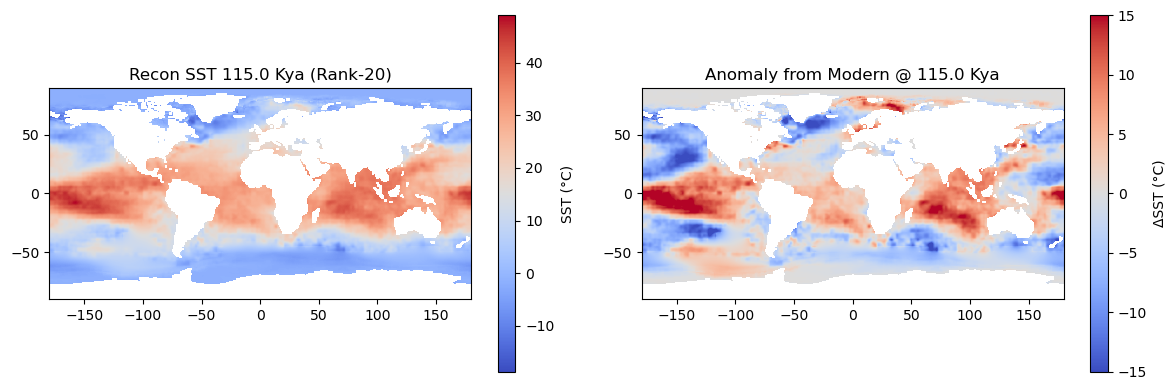

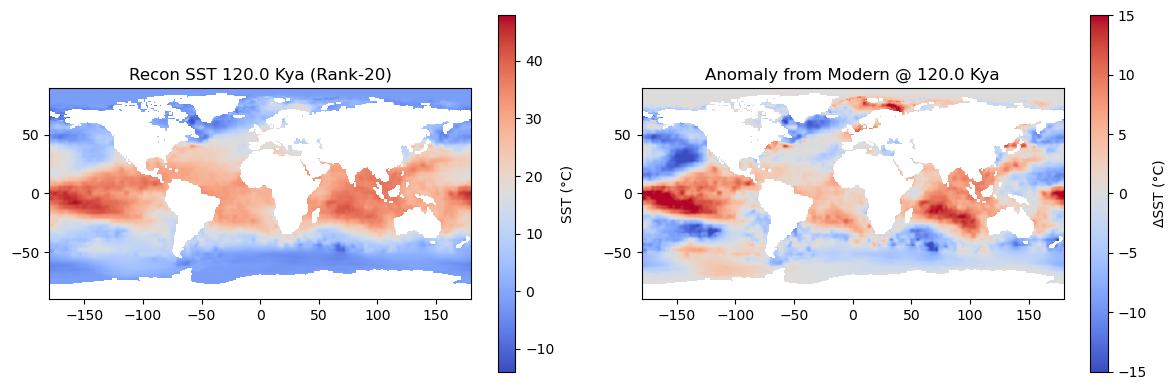

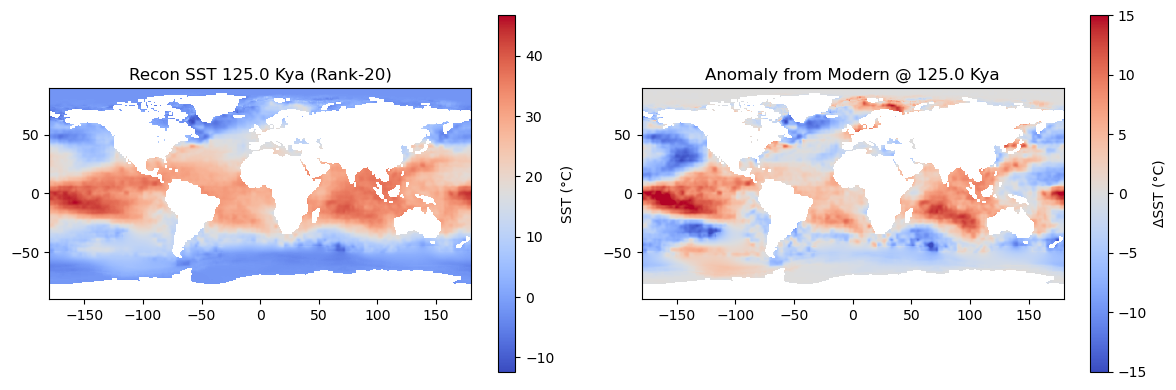

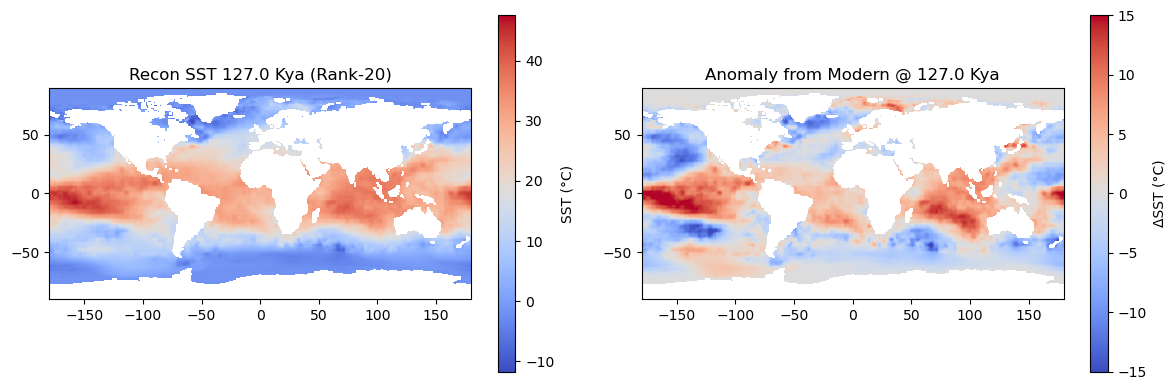

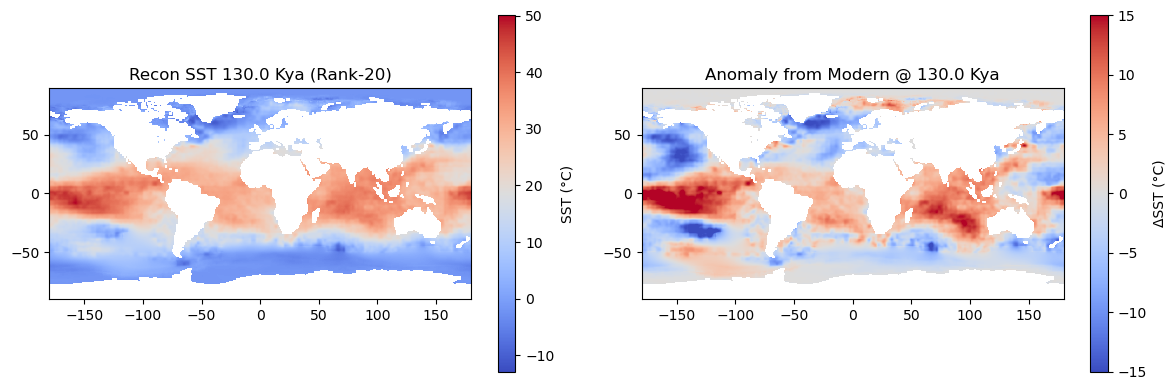

Saved paleo_sst_anomaly_reverse.gif


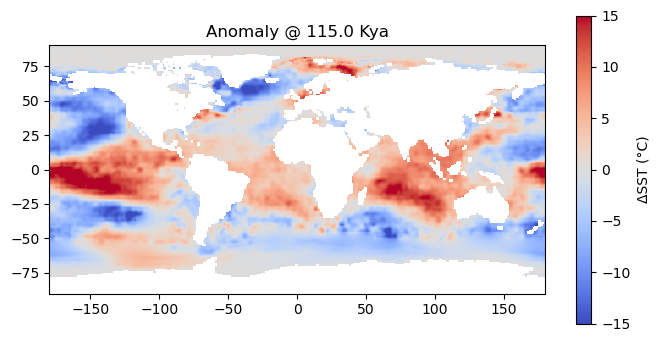

In [27]:
# ------------------------------------------------------------------------
# 9) Static maps for select ages
# ------------------------------------------------------------------------
ages = [115.0, 120.0, 125.0, 127.0, 130.0]
idxs = [int((age - 115.0) / 0.1) for age in ages]
for age, i in zip(ages, idxs):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    im0 = ax[0].imshow(
        all_abs[i], origin='lower', extent=[-180,180,-90,90], cmap='coolwarm'
    )
    ax[0].set_title(f'Recon SST {age:.1f} Kya (Rank-{r})')
    plt.colorbar(im0, ax=ax[0], label='SST (°C)')
    im1 = ax[1].imshow(
        all_anom[i], origin='lower', extent=[-180,180,-90,90],
        cmap='coolwarm', vmin=-15,
        vmax=15
    )
    ax[1].set_title(f'Anomaly from Modern @ {age:.1f} Kya')
    plt.colorbar(im1, ax=ax[1], label='ΔSST (°C)')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# 10) Animation of anomaly in reverse time
# ------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))
vmin, vmax = -15, 15
im = ax.imshow(
    all_anom[-1], origin='lower', extent=[-180,180,-90,90],
    cmap='coolwarm', vmin=vmin, vmax=vmax
)
cbar = fig.colorbar(im, ax=ax, label='ΔSST (°C)')
title = ax.set_title(f'Anomaly @ 130.0 Kya')

def update(frame):
    idx = T_paleo - 1 - frame
    age = 115.0 + 0.1 * idx
    im.set_array(all_anom[idx])
    title.set_text(f'Anomaly @ {age:.1f} Kya')
    return im, title

anim = animation.FuncAnimation(fig, update, frames=T_paleo, blit=True)
anim.save('paleo_sst_anomaly_reverse.gif', writer='pillow', fps=30)
print("Saved paleo_sst_anomaly_reverse.gif")

### Step 3.1 Assumptions

### Step 3.2 Constructing Global Modern SST Data Matrix X and
### Step 3.3 SVD and PCA on Modern SST Data

In [4]:
# 1) Load HadISST, clamp < –10°C, select first 1200 months, compute annual means
HadISST = xr.open_dataset('HadISST_sst.nc')
HadISST = HadISST.where(HadISST.sst > -10)
HadISST = HadISST.isel(time=slice(0, 1200))
HadISST_annual = HadISST.sst.groupby("time.year").mean("time", skipna=True)
HadISST_annual = HadISST_annual.sortby("latitude")  # lat running –90→+90

# 2) Extract raw array and flatten
X_raw = HadISST_annual.values         # shape = (100, 180, 360)
T, nlat, nlon = X_raw.shape           # T=100, nlat=180, nlon=360
Nraw = nlat * nlon                     # 64800 total grid cells
X_full = X_raw.reshape(T, Nraw)       # shape = (100, 64800)

# 3) Mask out “always-NaN” columns (pure land) to get X modern (100×N)
valid_col_mask = ~np.all(np.isnan(X_full), axis=0)  # length=64800
X = X_full[:, valid_col_mask]                       # shape = (100, N)

# 4) Build anomaly matrix B = X – (row mean), shape (100, N)
row_means = np.nanmean(X, axis=1, keepdims=True)   # shape = (100, 1)
B = X - row_means                                  # shape = (100, N)

# 5) SVD: B = U Σ Vᵀ
U, s, Vt = np.linalg.svd(B, full_matrices=False)
n_modes = 20
Modern_Weights = U[:, :n_modes] * s[:n_modes][np.newaxis, :]   # shape = (100, 20)
Modern_PC_truncated = Vt[:n_modes, :]                          # shape = (20, N)
Modern_PC = np.full((n_modes, Nraw), np.nan)
Modern_PC[:, valid_col_mask] = Modern_PC_truncated             # shape = (20, 64800)


Variance Explained by Each of the First 20 Modes:
  Mode  1:  99.95%
  Mode  2:   0.01%
  Mode  3:   0.01%
  Mode  4:   0.00%
  Mode  5:   0.00%
  Mode  6:   0.00%
  Mode  7:   0.00%
  Mode  8:   0.00%
  Mode  9:   0.00%
  Mode 10:   0.00%
  Mode 11:   0.00%
  Mode 12:   0.00%
  Mode 13:   0.00%
  Mode 14:   0.00%
  Mode 15:   0.00%
  Mode 16:   0.00%
  Mode 17:   0.00%
  Mode 18:   0.00%
  Mode 19:   0.00%
  Mode 20:   0.00%


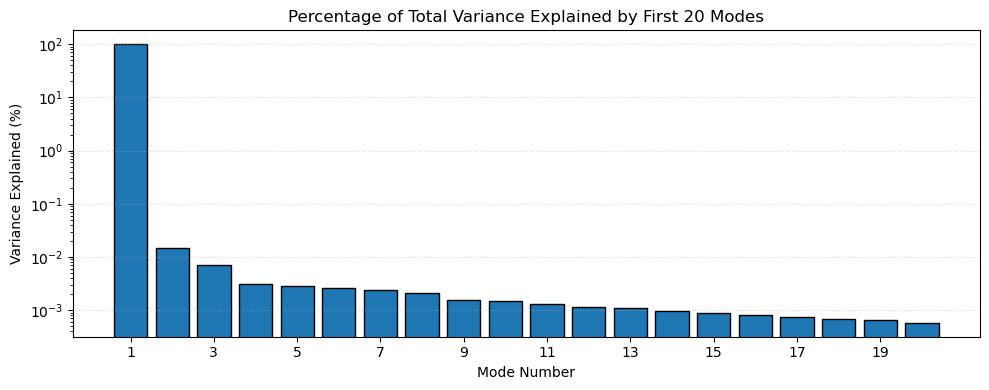

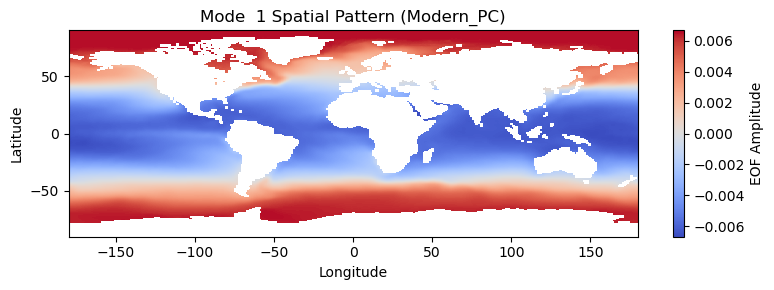

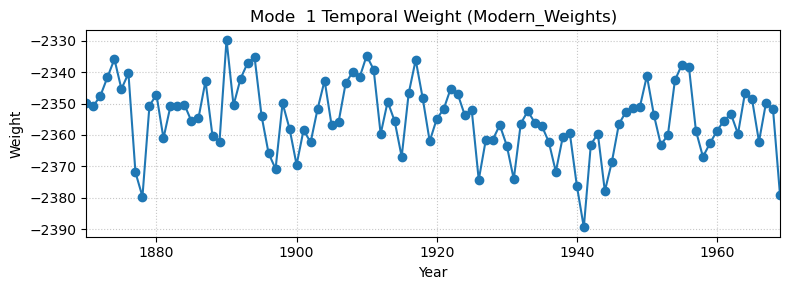

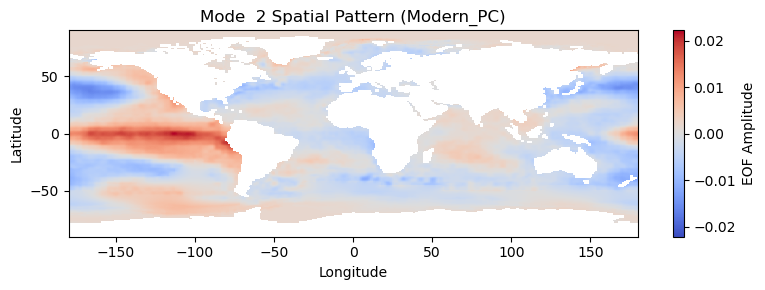

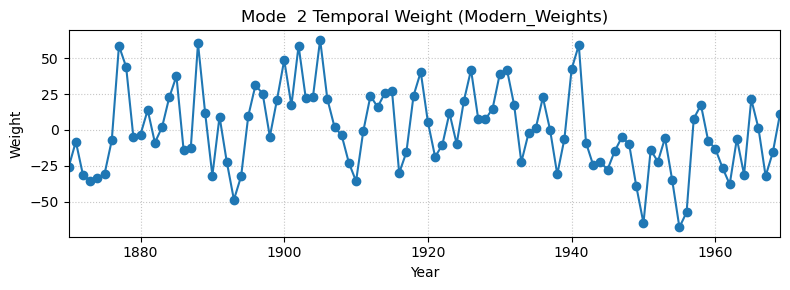

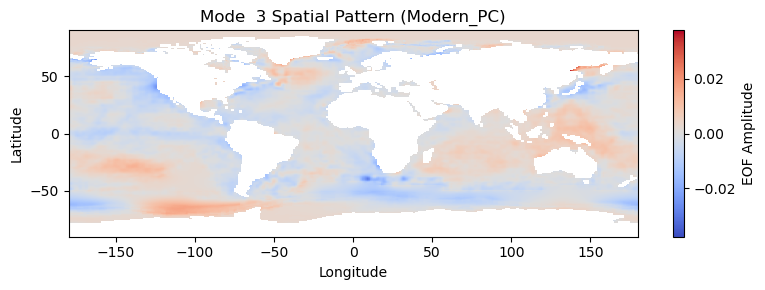

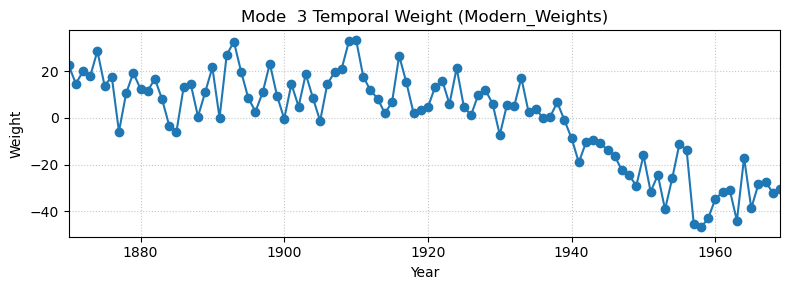

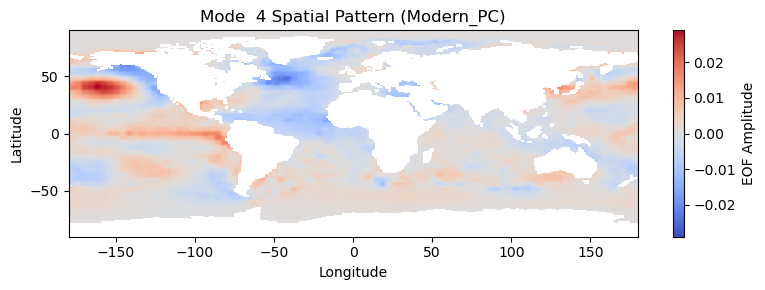

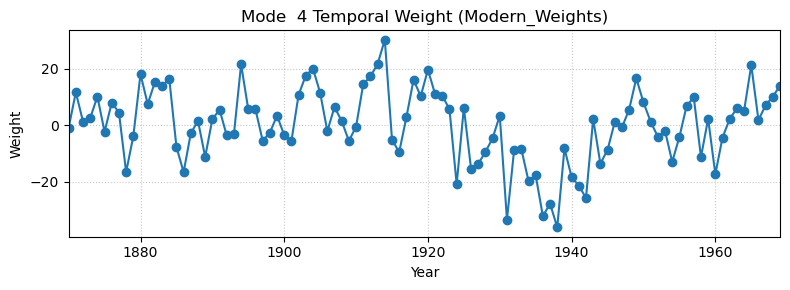

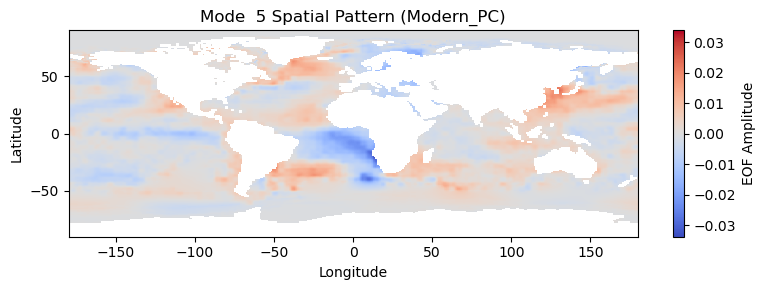

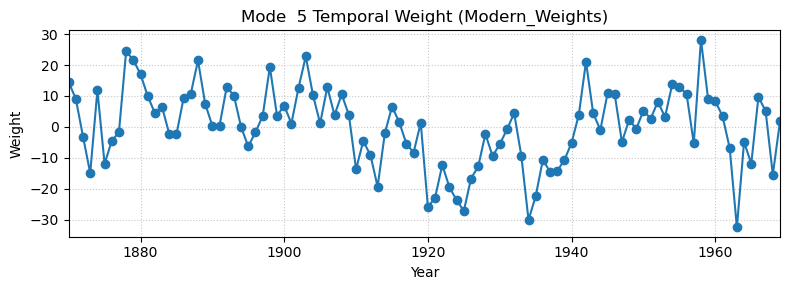

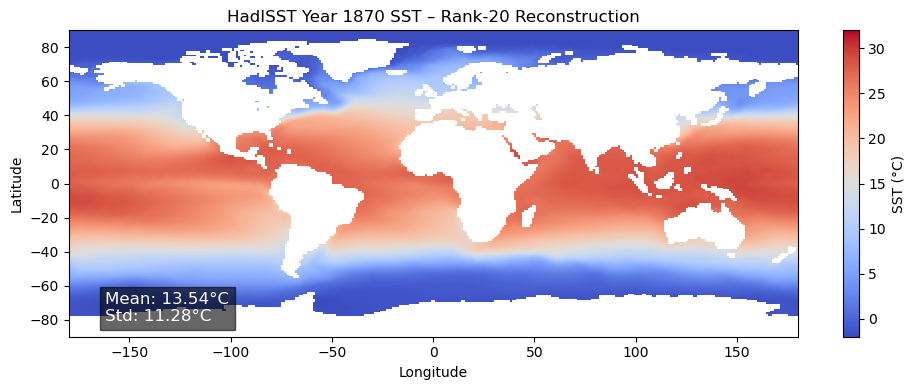

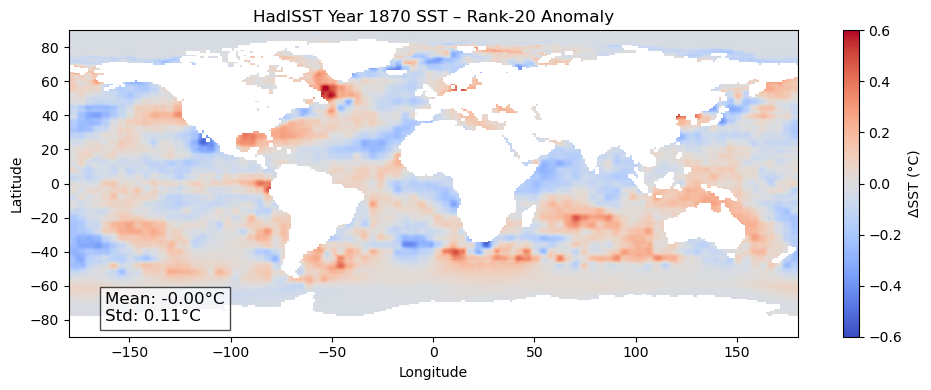

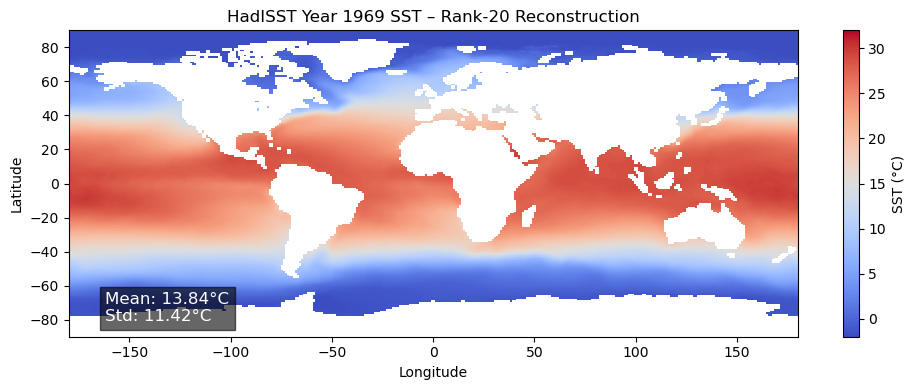

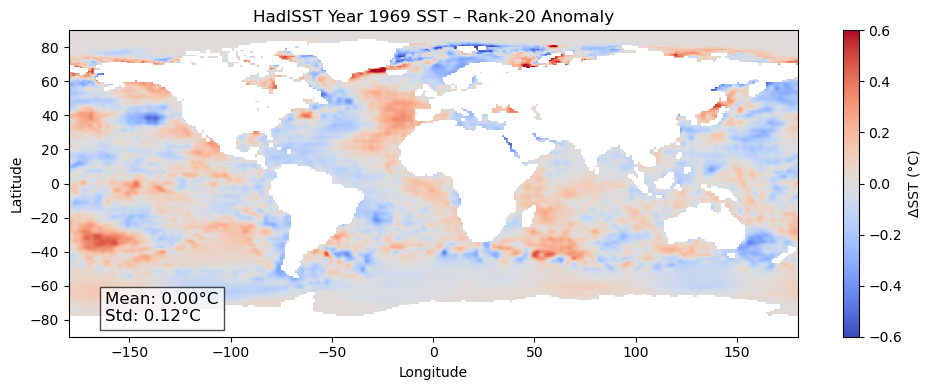

In [5]:
# Plot SVD results for spatial and temporal patterns

# 11) Compute percentage of total variance explained by each of the first 20 modes
total_variance = np.sum(s**2)
var_explained = (s[:n_modes]**2) / total_variance * 100

# Print percentages for first 20 modes
print("Variance Explained by Each of the First 20 Modes:")
for i, pct in enumerate(var_explained, start=1):
    print(f"  Mode {i:2d}: {pct:6.2f}%")

# Plot variance explained bar chart
plt.figure(figsize=(10, 4))
plt.bar(np.arange(1, n_modes+1), var_explained, edgecolor='black')
plt.yscale('log')  # set y‐axis to log scale
plt.xlabel('Mode Number')
plt.ylabel('Variance Explained (%)')
plt.title('Percentage of Total Variance Explained by First 20 Modes')
plt.xticks(np.arange(1, n_modes+1, 2))
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# 12) Plot only the first 5 modes: spatial pattern and temporal weight
years = np.arange(1870, 1970)

for mode in range(5):
    # Spatial pattern of Modern_PC for this mode
    pc_map = Modern_PC[mode, :].reshape(nlat, nlon)
    fig, ax = plt.subplots(figsize=(8, 3))
    im = ax.imshow(
        pc_map,
        origin='lower',
        extent=[-180, 180, -90, 90],
        aspect='auto',
        cmap='coolwarm',
        vmin=-np.nanmax(np.abs(pc_map)),
        vmax=np.nanmax(np.abs(pc_map))
    )
    ax.set_title(f'Mode {mode+1:2d} Spatial Pattern (Modern_PC)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    plt.colorbar(im, ax=ax, label='EOF Amplitude')
    plt.tight_layout()
    plt.show()
    
    # Temporal weight time series for this mode
    weight_series = Modern_Weights[:, mode]
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(years, weight_series, marker='o', linestyle='-')
    ax.set_title(f'Mode {mode+1:2d} Temporal Weight (Modern_Weights)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Weight')
    ax.set_xlim(1870, 1969)
    ax.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 13) Helper to reconstruct a single year at rank-20
def reconstruct_year(t):
    """
    Reconstruct the 1×64800 SST for year t (0-based), using all 20 modes:
      B_hat_flat = Modern_Weights[t,:] @ Modern_PC      # anomaly
      X_hat_flat = B_hat_flat + row_means[t, 0]
    Returns a length‐64800 array to reshape into 180×360.
    """
    Wt = Modern_Weights[t, :]                   # shape = (20,)
    B_hat_flat = Wt @ Modern_PC                 # (20,)·(20×64800) → (64800,)
    X_hat_flat = B_hat_flat + row_means[t, 0]   # add back the row‐mean
    return X_hat_flat

# 14) Plot rank-20 reconstructions for 1870 (t=0) and 1969 (t=99), including mean & std
for (year_index, calendar_year) in [(0, 1870), (99, 1969)]:
    # 14a) Reconstructed SST (20-mode)
    Xhat_flat = reconstruct_year(year_index)
    Xhat_map  = Xhat_flat.reshape(nlat, nlon)
    real_map  = X_full[year_index, :].reshape(nlat, nlon)

    # Compute mean & std of the reconstructed SST
    mean_recon = np.nanmean(Xhat_map)
    std_recon  = np.nanstd(Xhat_map)

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(
        Xhat_map,
        origin='lower',
        extent=[-180, 180, -90, 90],
        aspect='auto',
        cmap='coolwarm',
        vmin=-2,
        vmax=32
    )
    ax.set_title(f'HadISST Year {calendar_year} SST – Rank-{n_modes} Reconstruction')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.text(
        0.05, 0.05,
        f'Mean: {mean_recon:.2f}°C\nStd: {std_recon:.2f}°C',
        transform=ax.transAxes,
        fontsize=12,
        color='white',
        bbox=dict(facecolor='black', alpha=0.6)
    )
    fig.colorbar(im, ax=ax, label='SST (°C)')
    plt.tight_layout()
    plt.show()

    # 14b) Plot the anomaly: (Reconstructed − Actual)
    diff = Xhat_map - real_map

    # Compute mean & std of the anomaly
    mean_diff = np.nanmean(diff)
    std_diff  = np.nanstd(diff)

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(
        diff,
        origin='lower',
        extent=[-180, 180, -90, 90],
        aspect='auto',
        cmap='coolwarm',
        vmin=-0.6,
        vmax=0.6
    )
    ax.set_title(f'HadISST Year {calendar_year} SST – Rank-{n_modes} Anomaly')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.text(
        0.05, 0.05,
        f'Mean: {mean_diff:.2f}°C\nStd: {std_diff:.2f}°C',
        transform=ax.transAxes,
        fontsize=12,
        color='black',
        bbox=dict(facecolor='white', alpha=0.7)
    )
    fig.colorbar(im, ax=ax, label='ΔSST (°C)')
    plt.tight_layout()
    plt.show()

#### Rank-30 Old SVD

Variance Explained by Each of the First 30 Modes:
  Mode  1:  99.95%
  Mode  2:   0.01%
  Mode  3:   0.01%
  Mode  4:   0.00%
  Mode  5:   0.00%
  Mode  6:   0.00%
  Mode  7:   0.00%
  Mode  8:   0.00%
  Mode  9:   0.00%
  Mode 10:   0.00%
  Mode 11:   0.00%
  Mode 12:   0.00%
  Mode 13:   0.00%
  Mode 14:   0.00%
  Mode 15:   0.00%
  Mode 16:   0.00%
  Mode 17:   0.00%
  Mode 18:   0.00%
  Mode 19:   0.00%
  Mode 20:   0.00%
  Mode 21:   0.00%
  Mode 22:   0.00%
  Mode 23:   0.00%
  Mode 24:   0.00%
  Mode 25:   0.00%
  Mode 26:   0.00%
  Mode 27:   0.00%
  Mode 28:   0.00%
  Mode 29:   0.00%
  Mode 30:   0.00%


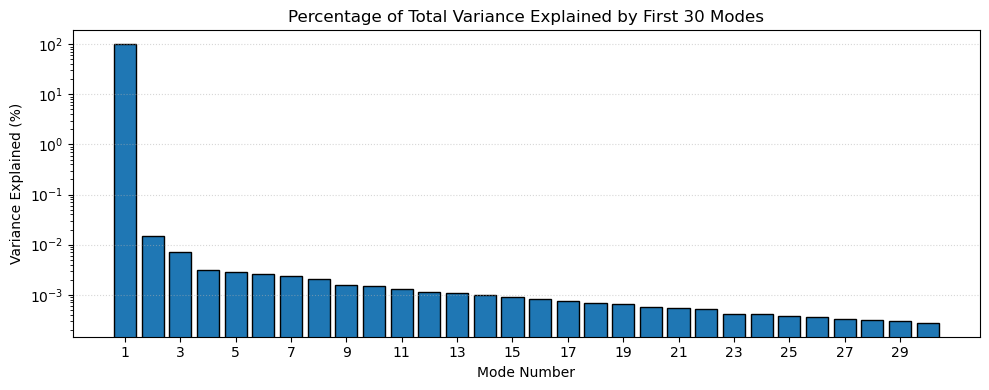

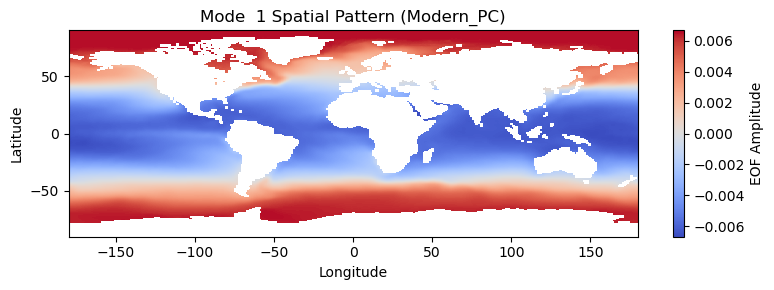

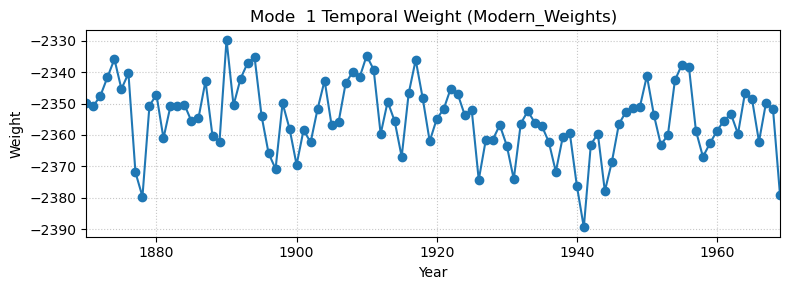

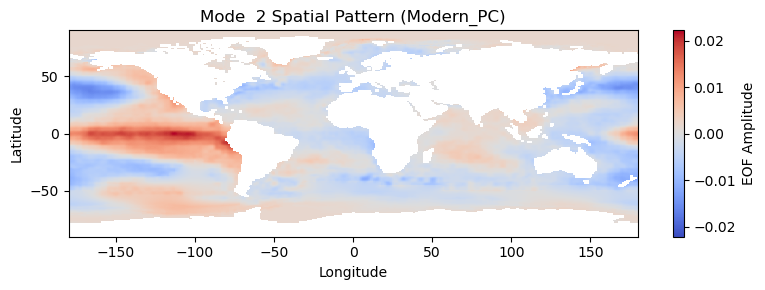

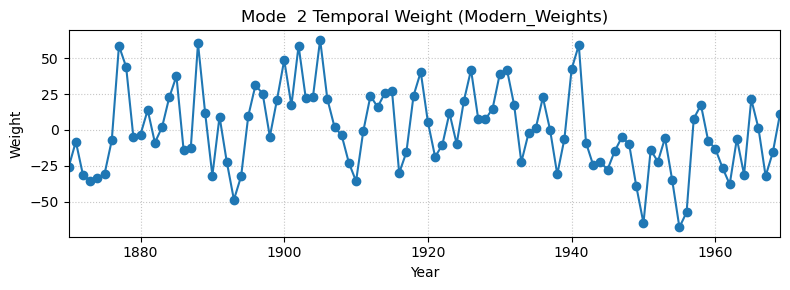

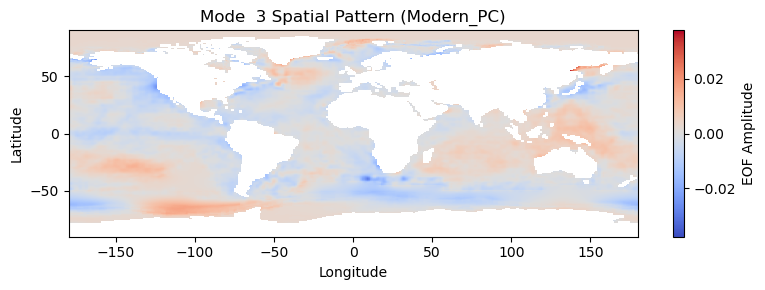

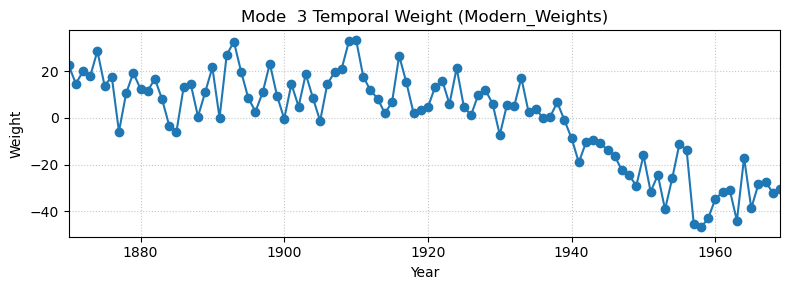

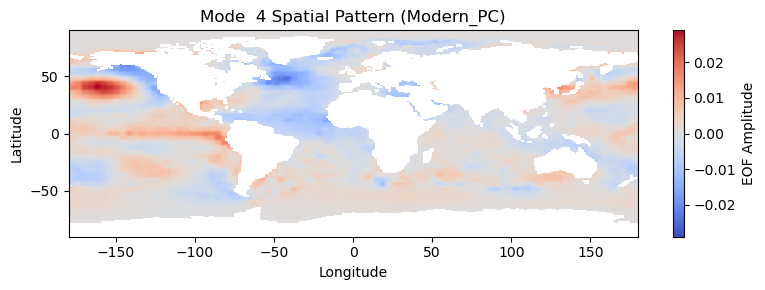

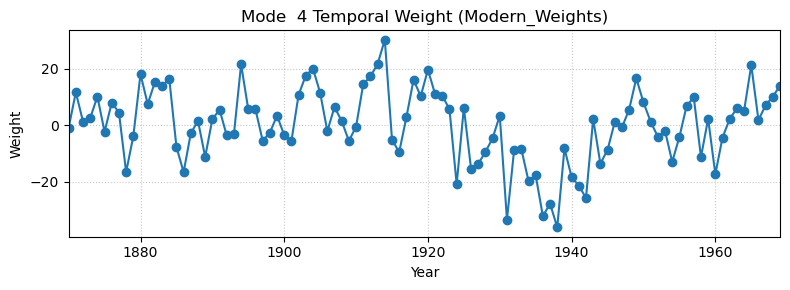

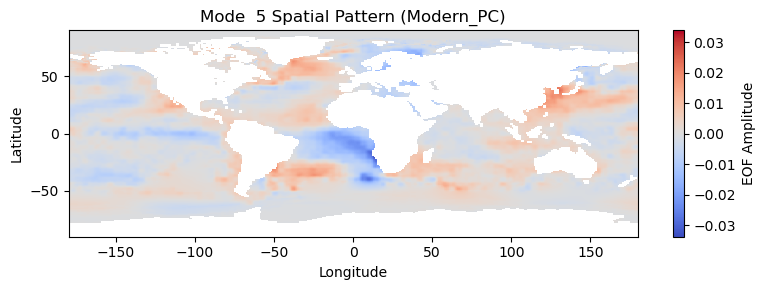

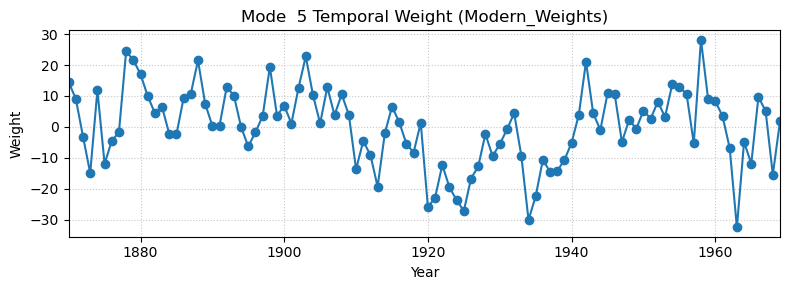

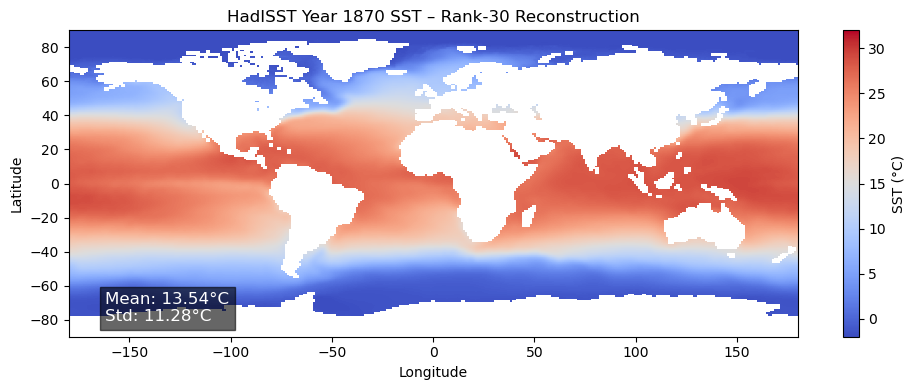

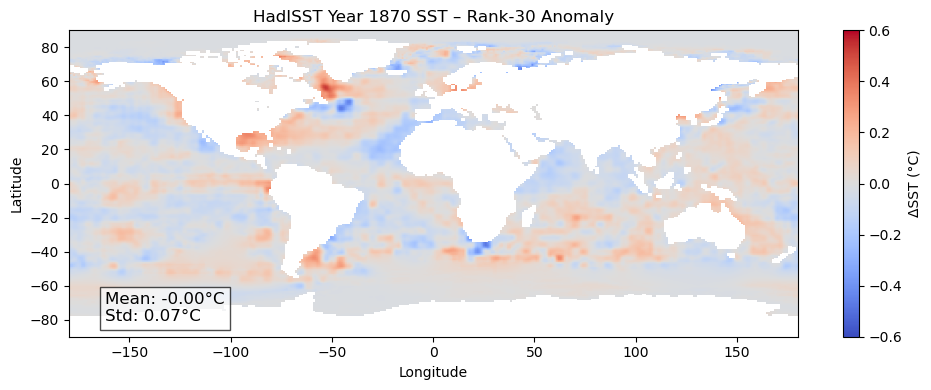

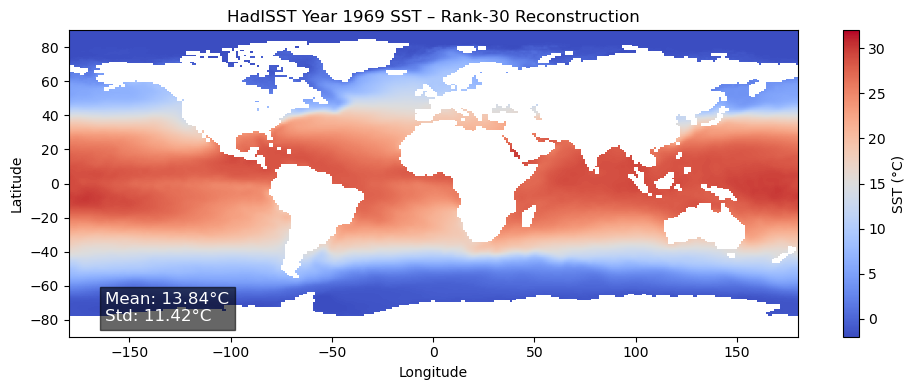

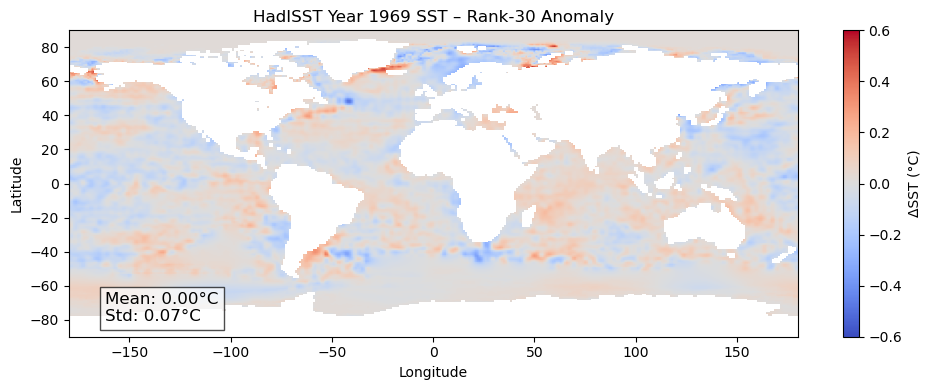

In [16]:
# 1) Load HadISST and clamp values below –10°C
HadISST = xr.open_dataset(ncfile)
HadISST = HadISST.where(HadISST.sst > -10)

# 2) Select the first 1200 months (1870–1969)
HadISST = HadISST.isel(time=slice(0, 1200))

# 3) Compute annual mean for each year: 1870–1969
HadISST_annual = HadISST.sst.groupby('time.year').mean('time', skipna=True)

# 4) Sort latitude from –90° to +90°
HadISST_annual = HadISST_annual.sortby('latitude')

# 5) Extract raw array: shape = (100, 180, 360)
X_raw = HadISST_annual.values
T, nlat, nlon = X_raw.shape  # T=100 years, nlat=180, nlon=360
Nraw = nlat * nlon           # 64800 grid cells

# 6) Flatten each 180×360 map into a length-64800 vector → X_full shape = (100, 64800)
X_full = X_raw.reshape(T, Nraw)

# 7) Drop “always-NaN” columns (land cells)
valid_col_mask = ~np.all(np.isnan(X_full), axis=0)  # boolean mask length=64800
X = X_full[:, valid_col_mask]                      # shape = (100, N)

# 8) Form anomaly matrix B by subtracting each row's spatial mean
row_means = np.nanmean(X, axis=1, keepdims=True)  # shape = (100, 1)
B = X - row_means                                 # shape = (100, N)

# 9) Perform SVD: B = U · Σ · Vᵀ
U, s, Vt = np.linalg.svd(B, full_matrices=False)
#    U.shape = (100, 100), s.shape = (100,), Vt.shape = (100, N)

# 10) Truncate to n_modes = 30
n_modes = 30
Modern_Weights = U[:, :n_modes] * s[:n_modes][np.newaxis, :]  # shape = (100, 30)
Modern_PC_truncated = Vt[:n_modes, :]                        # shape = (30, N)
Modern_PC = np.full((n_modes, Nraw), np.nan)
Modern_PC[:, valid_col_mask] = Modern_PC_truncated           # shape = (30, 64800)

# 11) Compute percentage of total variance explained by each of the first 30 modes
total_variance = np.sum(s**2)
var_explained = (s[:n_modes]**2) / total_variance * 100

# Print percentages for first 30 modes
print("Variance Explained by Each of the First 30 Modes:")
for i, pct in enumerate(var_explained, start=1):
    print(f"  Mode {i:2d}: {pct:6.2f}%")

# Plot variance explained bar chart
plt.figure(figsize=(10, 4))
plt.bar(np.arange(1, n_modes+1), var_explained, edgecolor='black')
plt.yscale('log')  # set y‐axis to log scale
plt.xlabel('Mode Number')
plt.ylabel('Variance Explained (%)')
plt.title('Percentage of Total Variance Explained by First 30 Modes')
plt.xticks(np.arange(1, n_modes+1, 2))
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# 12) Plot only the first 5 modes: spatial pattern and temporal weight
years = np.arange(1870, 1970)

for mode in range(5):
    # Spatial pattern of Modern_PC for this mode
    pc_map = Modern_PC[mode, :].reshape(nlat, nlon)
    fig, ax = plt.subplots(figsize=(8, 3))
    im = ax.imshow(
        pc_map,
        origin='lower',
        extent=[-180, 180, -90, 90],
        aspect='auto',
        cmap='coolwarm',
        vmin=-np.nanmax(np.abs(pc_map)),
        vmax=np.nanmax(np.abs(pc_map))
    )
    ax.set_title(f'Mode {mode+1:2d} Spatial Pattern (Modern_PC)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    plt.colorbar(im, ax=ax, label='EOF Amplitude')
    plt.tight_layout()
    plt.show()
    
    # Temporal weight time series for this mode
    weight_series = Modern_Weights[:, mode]
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(years, weight_series, marker='o', linestyle='-')
    ax.set_title(f'Mode {mode+1:2d} Temporal Weight (Modern_Weights)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Weight')
    ax.set_xlim(1870, 1969)
    ax.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 13) Helper to reconstruct a single year at rank-30
def reconstruct_year(t):
    """
    Reconstruct the 1×64800 SST for year t (0-based), using all 30 modes:
      B_hat_flat = Modern_Weights[t,:] @ Modern_PC      # anomaly
      X_hat_flat = B_hat_flat + row_means[t, 0]
    Returns a length‐64800 array to reshape into 180×360.
    """
    Wt = Modern_Weights[t, :]                   # shape = (30,)
    B_hat_flat = Wt @ Modern_PC                 # (30,)·(30×64800) → (64800,)
    X_hat_flat = B_hat_flat + row_means[t, 0]   # add back the row‐mean
    return X_hat_flat

# 14) Plot rank-30 reconstructions for 1870 (t=0) and 1969 (t=99), including mean & std
for (year_index, calendar_year) in [(0, 1870), (99, 1969)]:
    # 14a) Reconstructed SST (30-mode)
    Xhat_flat = reconstruct_year(year_index)
    Xhat_map  = Xhat_flat.reshape(nlat, nlon)
    real_map  = X_full[year_index, :].reshape(nlat, nlon)

    # Compute mean & std of the reconstructed SST
    mean_recon = np.nanmean(Xhat_map)
    std_recon  = np.nanstd(Xhat_map)

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(
        Xhat_map,
        origin='lower',
        extent=[-180, 180, -90, 90],
        aspect='auto',
        cmap='coolwarm',
        vmin=-2,
        vmax=32
    )
    ax.set_title(f'HadISST Year {calendar_year} SST – Rank-{n_modes} Reconstruction')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.text(
        0.05, 0.05,
        f'Mean: {mean_recon:.2f}°C\nStd: {std_recon:.2f}°C',
        transform=ax.transAxes,
        fontsize=12,
        color='white',
        bbox=dict(facecolor='black', alpha=0.6)
    )
    fig.colorbar(im, ax=ax, label='SST (°C)')
    plt.tight_layout()
    plt.show()

    # 14b) Plot the anomaly: (Reconstructed − Actual)
    diff = Xhat_map - real_map

    # Compute mean & std of the anomaly
    mean_diff = np.nanmean(diff)
    std_diff  = np.nanstd(diff)

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(
        diff,
        origin='lower',
        extent=[-180, 180, -90, 90],
        aspect='auto',
        cmap='coolwarm',
        vmin=-0.6,
        vmax=0.6
    )
    ax.set_title(f'HadISST Year {calendar_year} SST – Rank-{n_modes} Anomaly')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.text(
        0.05, 0.05,
        f'Mean: {mean_diff:.2f}°C\nStd: {std_diff:.2f}°C',
        transform=ax.transAxes,
        fontsize=12,
        color='black',
        bbox=dict(facecolor='white', alpha=0.7)
    )
    fig.colorbar(im, ax=ax, label='ΔSST (°C)')
    plt.tight_layout()
    plt.show()


### Step 3.4 Multi-linear Regression Fitting
#### Switch to Ridge regression with an intercept term (choose α via cross‐validation on the 100 modern years)

In [7]:
# 1) Read all sheet names from the Excel file and skip “info sheets”
excel_file = "SST_Hoffman_Harmonized_AC_ES.xlsx"
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names
non_sst_sheets = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me"
]

records = []
for sheet in sheet_names:
    if sheet in non_sst_sheets:
        continue
    # 1a) Read ID, original lon/lat from rows A–C
    try:
        df_base = pd.read_excel(
            excel_file,
            sheet_name=sheet,
            header=None,
            usecols="A:C",
            nrows=2
        )
        ID = sheet
        origin_lon = df_base.iloc[1, 1]
        origin_lat = df_base.iloc[1, 2]
    except Exception:
        continue
    records.append({"ID": ID, "origin_lon": origin_lon, "origin_lat": origin_lat})

# 2) Build DataFrame of all cores
df_LIG = pd.DataFrame(records)

# 3) Round to nearest 0.5° (to match HadISST grid)
def round_to_nearest_half(x):
    base = np.floor(x)
    return base + 0.5

df_LIG["round_lon"] = df_LIG["origin_lon"].apply(round_to_nearest_half)
df_LIG["round_lat"] = df_LIG["origin_lat"].apply(round_to_nearest_half)
df_LIG["round_lon"] = df_LIG["round_lon"].clip(lower=-179.5, upper=179.5)
df_LIG["round_lat"] = df_LIG["round_lat"].clip(lower=-89.5,  upper=89.5)

# 4) Remove replicated cores (using to_drop_positions)
dup_mask = df_LIG.duplicated(subset=["round_lon", "round_lat"], keep=False)
to_drop_positions = [1,5,17,21,39,64,73,57,71,76,79,80,82,84,85,88,90,91,94,97,99,102]
valid_positions = [pos for pos in to_drop_positions if pos < len(df_LIG)]
df_LIG.drop(index=df_LIG.index[valid_positions], inplace=True)
df_LIG = df_LIG.reset_index(drop=True)  # re-index from 0→81

assert df_LIG.shape[0] == 82
M = df_LIG[["ID", "origin_lon", "origin_lat", "round_lon", "round_lat"]].copy()

# 5) Build matrix F (100 × 82) by extracting modern SST at each core’s (round_lat, round_lon)
lats = HadISST_annual.latitude.values   # shape = (180,), –90→+90
lons = HadISST_annual.longitude.values  # shape = (360,), –179.5→+179.5

def find_index(arr, value):
    return int(np.where(np.isclose(arr, value))[0])

T_modern = T  # 100
N_cores = M.shape[0]  # 82
F = np.full((T_modern, N_cores), np.nan)

for j in range(N_cores):
    rl = M.loc[j, "round_lat"]
    ro = M.loc[j, "round_lon"]
    i_lat = find_index(lats, rl)
    i_lon = find_index(lons, ro)
    F[:, j] = HadISST_annual.values[:, i_lat, i_lon]  # (100,)

# 6) Standardize F row-wise: subtract each row’s mean (no division by σ)
row_mean_F = np.nanmean(F, axis=1, keepdims=True)  # (100,1)
F_anom = F - row_mean_F                            # (100,82)

# 7) Solve multi-linear regression with Ridge (includes intercept)
ridge = Ridge(alpha=1.0, fit_intercept=True)
ridge.fit(F_anom, Modern_Weights)      # fits 20 target columns in parallel
Beta = ridge.coef_.T                   # shape = (82, 20)
Intercept = ridge.intercept_           # shape = (20,)

#### Rank-30 Old, regression is without ridge nor intercept

In [32]:
# 1) Read all sheet names from the Excel file and skip “info sheets”
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names
non_sst_sheets = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me"
]

records = []
for sheet in sheet_names:
    if sheet in non_sst_sheets:
        continue
    # 1a) Read ID, original lon/lat from rows A–C
    try:
        df_base = pd.read_excel(
            excel_file,
            sheet_name=sheet,
            header=None,
            usecols="A:C",
            nrows=2
        )
        ID = sheet
        origin_lon = df_base.iloc[1, 1]
        origin_lat = df_base.iloc[1, 2]
    except Exception:
        continue
    records.append({"ID": ID, "origin_lon": origin_lon, "origin_lat": origin_lat})

# 2) Build DataFrame of all cores
df_LIG = pd.DataFrame(records)

# 3) Round to nearest 0.5° (to match HadISST grid)
def round_to_nearest_half(x):
    base = np.floor(x)
    return base + 0.5

df_LIG["round_lon"] = df_LIG["origin_lon"].apply(round_to_nearest_half)
df_LIG["round_lat"] = df_LIG["origin_lat"].apply(round_to_nearest_half)
df_LIG["round_lon"] = df_LIG["round_lon"].clip(lower=-179.5, upper=179.5)
df_LIG["round_lat"] = df_LIG["round_lat"].clip(lower=-89.5,  upper=89.5)

# 4) Remove replicated cores (using to_drop_positions)
dup_mask = df_LIG.duplicated(subset=["round_lon", "round_lat"], keep=False)
to_drop_positions = [1,5,17,21,39,64,73,57,71,76,79,80,82,84,85,88,90,91,94,97,99,102]
valid_positions = [pos for pos in to_drop_positions if pos < len(df_LIG)]
df_LIG.drop(index=df_LIG.index[valid_positions], inplace=True)
df_LIG = df_LIG.reset_index(drop=True)  # re-index from 0→81

assert df_LIG.shape[0] == 82
M = df_LIG[["ID", "origin_lon", "origin_lat", "round_lon", "round_lat"]].copy()

# 5) Build matrix F (100 × 82) by extracting modern SST at each core’s (round_lat, round_lon)
lats = HadISST_annual.latitude.values   # shape = (180,), –90→+90
lons = HadISST_annual.longitude.values  # shape = (360,), –179.5→+179.5

def find_index(arr, value):
    return int(np.where(np.isclose(arr, value))[0])

T_modern = T  # 100
N_cores = M.shape[0]  # 82
F = np.full((T_modern, N_cores), np.nan)

for j in range(N_cores):
    rl = M.loc[j, "round_lat"]
    ro = M.loc[j, "round_lon"]
    i_lat = find_index(lats, rl)
    i_lon = find_index(lons, ro)
    F[:, j] = HadISST_annual.values[:, i_lat, i_lon]  # (100,)

# 6) Standardize F row-wise: subtract each row’s mean (no division by σ)
row_mean_F = np.nanmean(F, axis=1, keepdims=True)  # (100,1)
F_anom = F - row_mean_F                            # (100,82)

# 7) Solve multi-linear regression: F_anom × Beta = Modern_Weights  ⇒ Beta is (82×30)
lr = LinearRegression(fit_intercept=False)
lr.fit(F_anom, Modern_Weights)     # fits 30 regressions in parallel
Beta = lr.coef_.T                   # Beta shape = (82, 30)

### Step 3.5 Reconstructing Full-Field Paleo SST

/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_1282/4080218641.py:38: RuntimeWarning: Mean of empty slice
  modern_mean_flat = np.nanmean(X_full, axis=0)  # shape = (64800,)


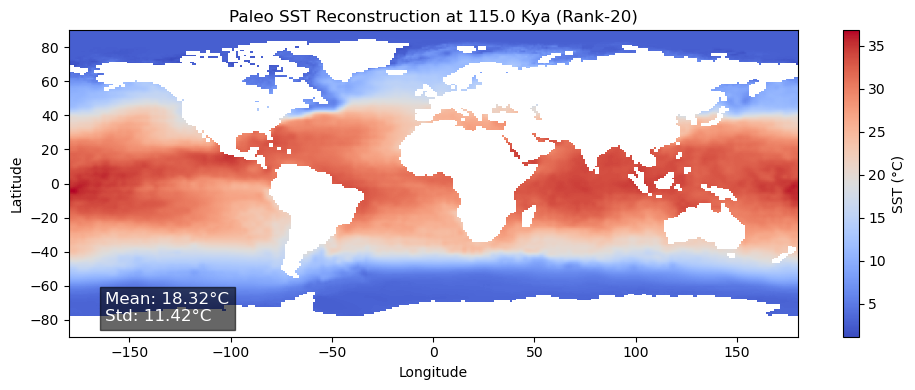

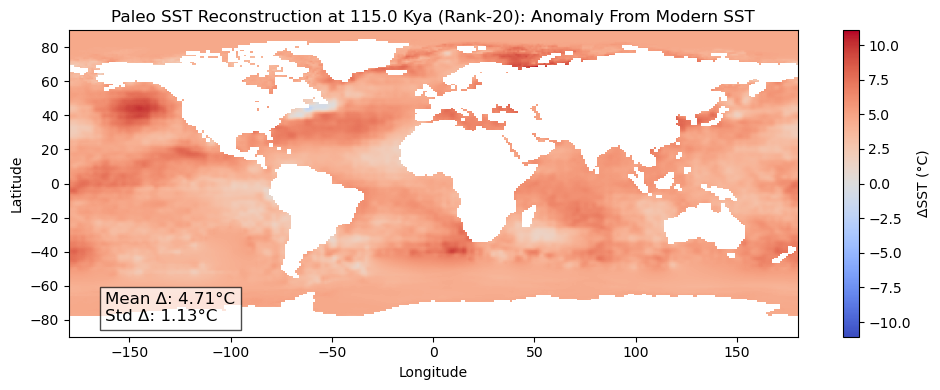

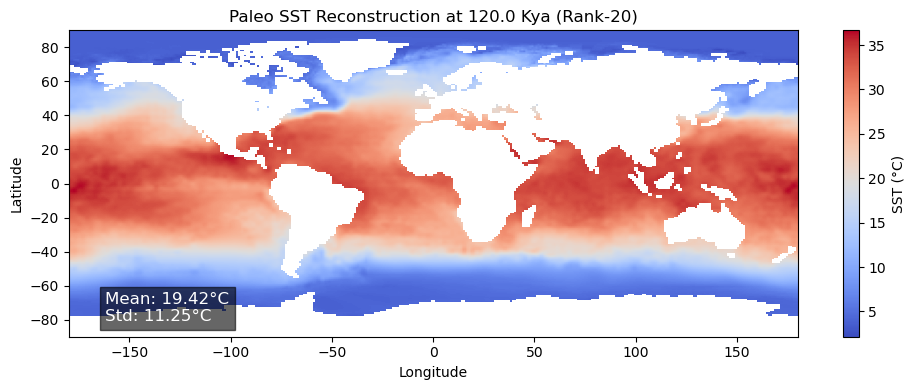

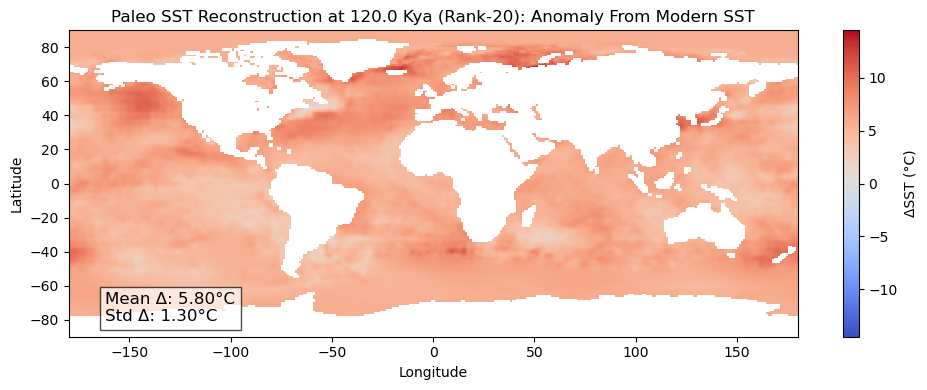

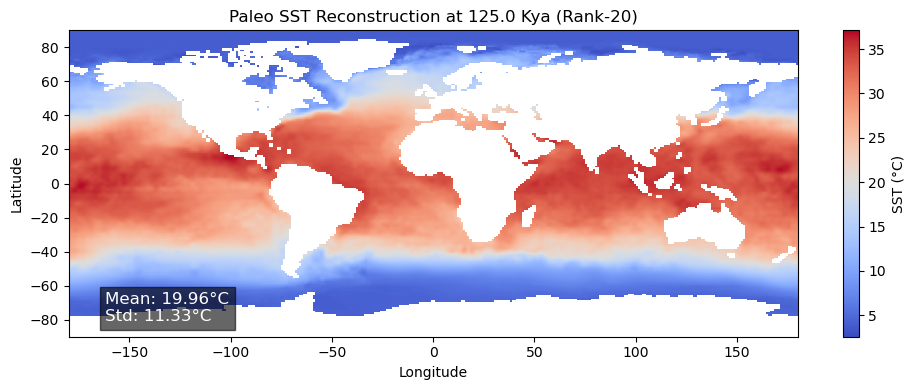

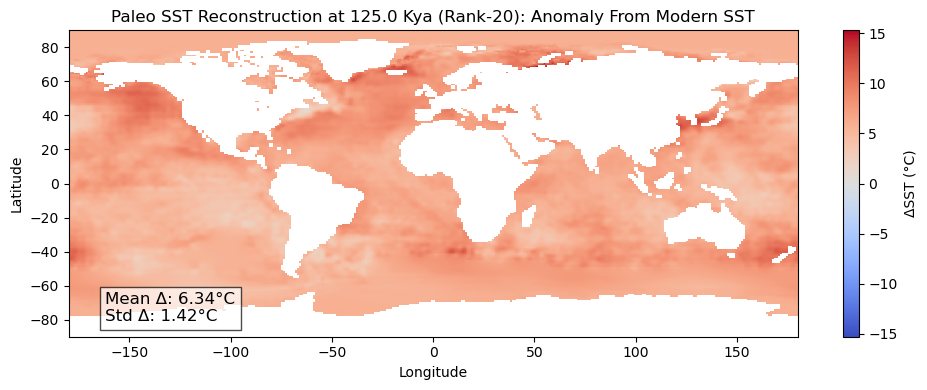

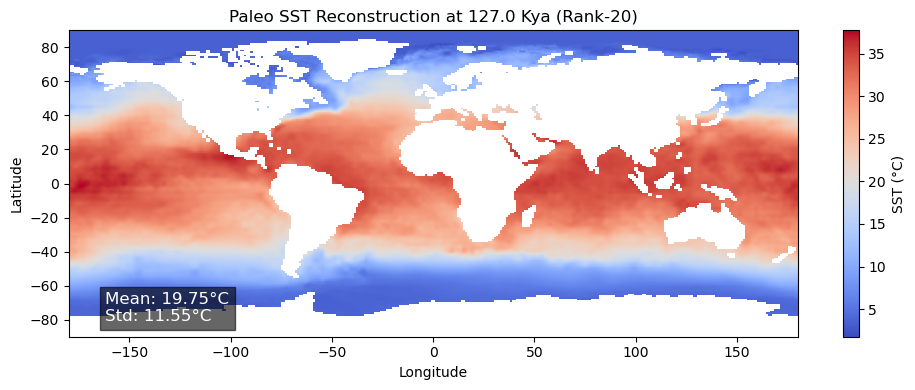

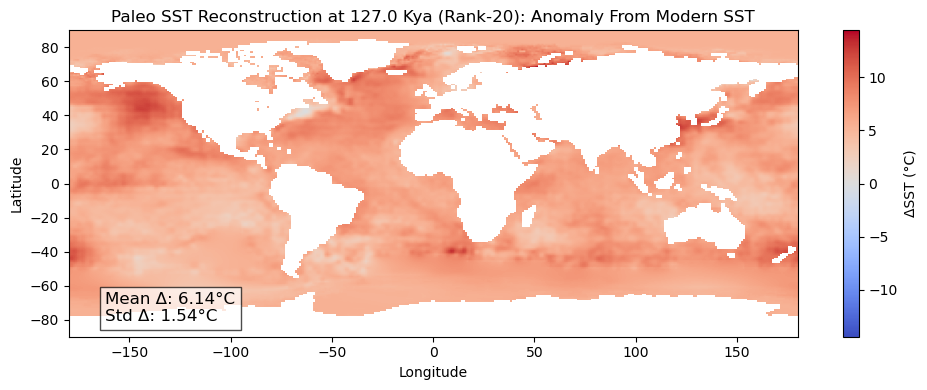

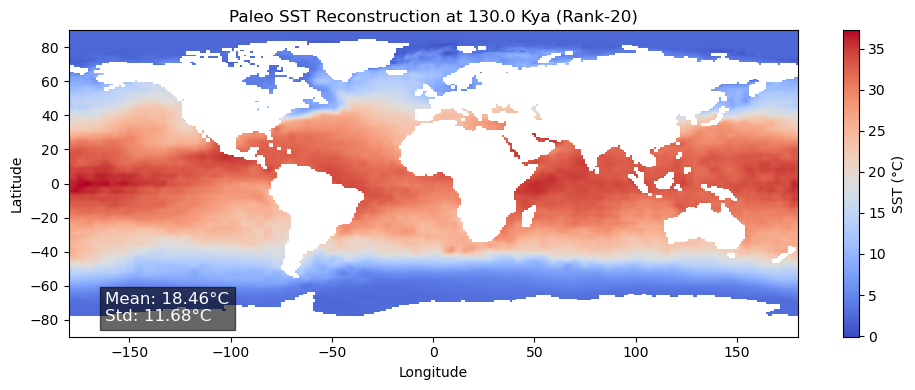

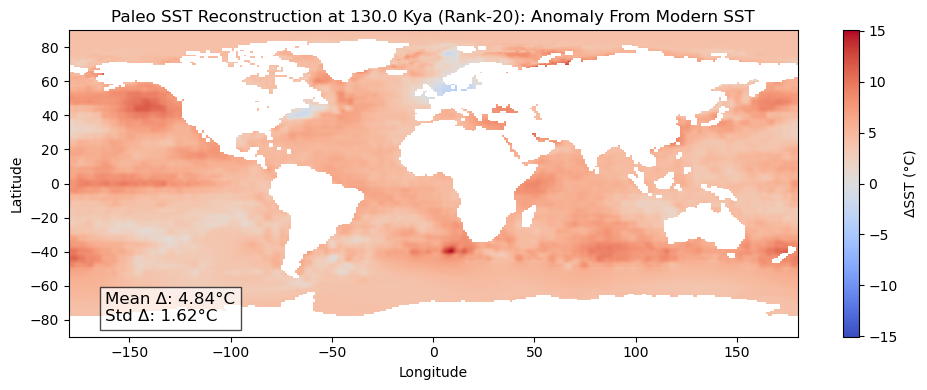

Paleo Variance Explained by Each of the 20 Modes:
  Mode  1:  98.52%
  Mode  2:   0.07%
  Mode  3:   0.22%
  Mode  4:   0.04%
  Mode  5:   0.01%
  Mode  6:   0.07%
  Mode  7:   0.00%
  Mode  8:   0.01%
  Mode  9:   0.07%
  Mode 10:   0.00%
  Mode 11:   0.37%
  Mode 12:   0.06%
  Mode 13:   0.02%
  Mode 14:   0.05%
  Mode 15:   0.14%
  Mode 16:   0.23%
  Mode 17:   0.04%
  Mode 18:   0.05%
  Mode 19:   0.03%
  Mode 20:   0.01%


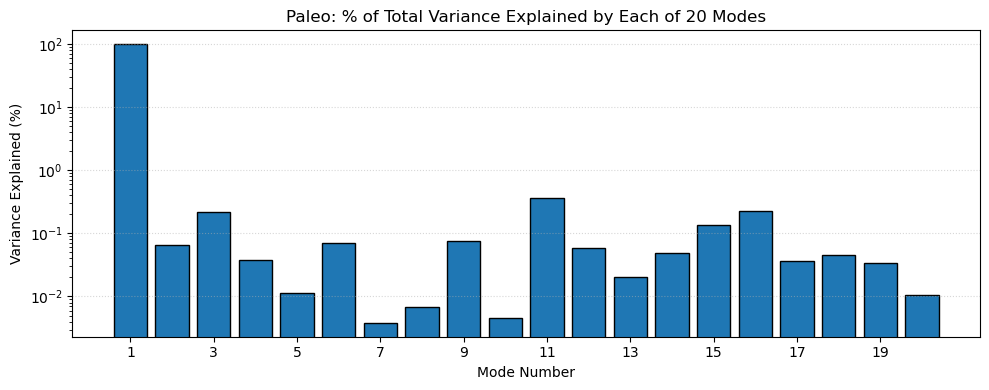

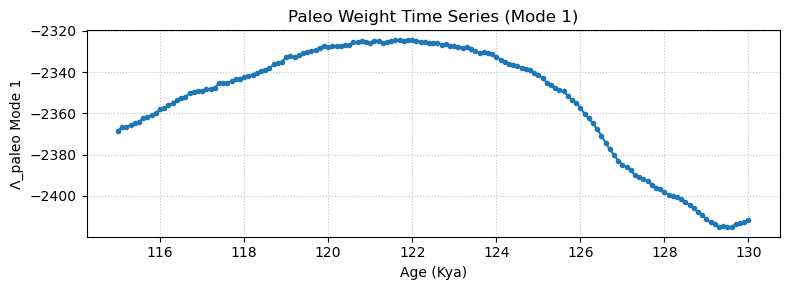

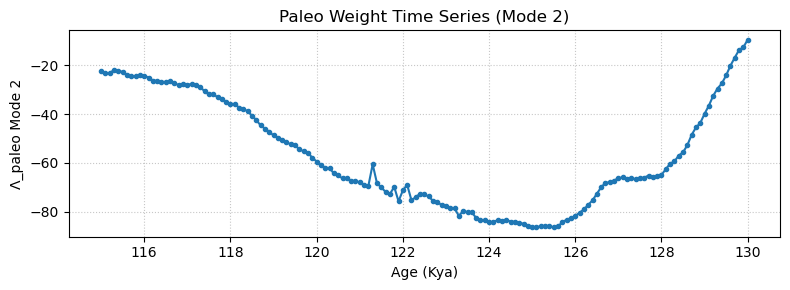

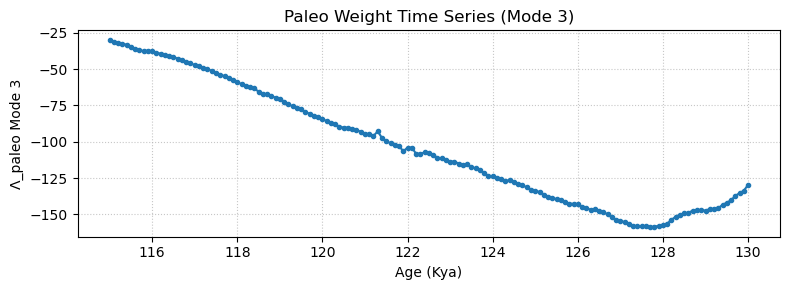

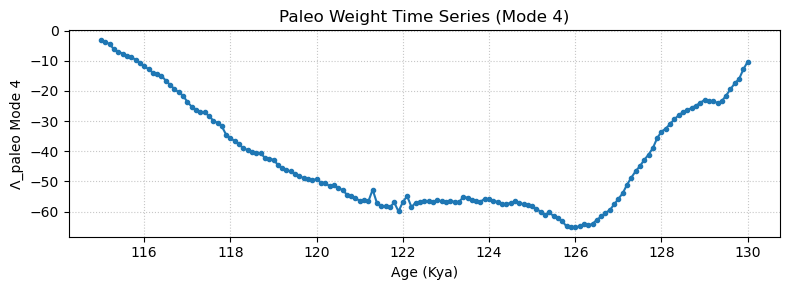

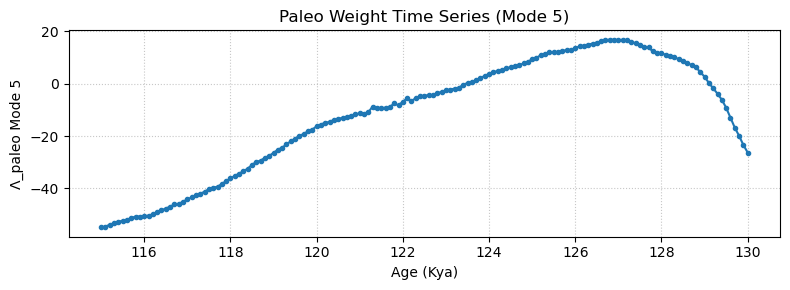

In [10]:
# 8) Build F_paleo (151 × 82) by reading column T (skip header), back-fill.
T_paleo = 151
F_paleo = np.full((T_paleo, N_cores), np.nan)

for j in range(N_cores):
    core_id = M.loc[j, "ID"]
    # Read column T, skip first row (header "SST mean"), next 151 rows are values
    df_sst_full = pd.read_excel(
        excel_file,
        sheet_name=core_id,
        header=None,
        usecols="T",
        skiprows=1,    # skip header row "SST mean"
        nrows=T_paleo
    )
    series = df_sst_full.iloc[:, 0]            # length = 151
    series_filled = series.fillna(method="bfill").values
    F_paleo[:, j] = series_filled

# 9) Standardize F_paleo row-wise: subtract each row’s mean (no division by σ)
row_mean_paleo = np.nanmean(F_paleo, axis=1, keepdims=True)  # (151,1)
F_paleo_anom = F_paleo - row_mean_paleo                        # (151,82)

# 10) Compute Lambda_paleo = F_paleo_anom × Beta + intercept term
#     We add the intercept vector to each time row before projecting.
#     Shape: (151×82) × (82×20) = (151×20); then add (151×1) broadcast to (151×20)
Lambda_paleo = F_paleo_anom.dot(Beta) + Intercept[np.newaxis, :]  # shape = (151, 20)

# 11) Reconstruct paleo SST anomaly on full 64800 grid: B_paleo = Lambda_paleo × Modern_PC
B_paleo = Lambda_paleo.dot(Modern_PC)  # (151×20) × (20×64800) ⇒ (151×64800)

# 12) Now compute absolute SST reconstruction for selected ages by adding back row_mean_paleo
#     Ages of interest: 115, 120, 125, 127, 130 Kya  ⇒ indices = 0, 50, 100, 120, 150
age_list = [115.0, 120.0, 125.0, 127.0, 130.0]
indices = [int(round((age - 115.0) / 0.1)) for age in age_list]  # [0, 50, 100, 120, 150]

# 13) Compute modern_mean_flat at each grid cell to create anomaly SST maps
modern_mean_flat = np.nanmean(X_full, axis=0)  # shape = (64800,)
modern_mean_map = modern_mean_flat.reshape(nlat, nlon)

# 14) Plot static maps for 5 paleo time slices
age_list = [115.0, 120.0, 125.0, 127.0, 130.0]
indices = [int(round((age - 115.0) / 0.1)) for age in age_list]  # [0, 50, 100, 120, 150]

for idx, age in zip(indices, age_list):
    # a) Absolute SST: anomaly + modern row mean
    absolute_flat = B_paleo[idx, :] + row_mean_paleo[idx, 0]      # length = 64800
    absolute_map = absolute_flat.reshape(nlat, nlon)

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(
        absolute_map,
        origin="lower",
        extent=[-180, 180, -90, 90],
        aspect="auto",
        cmap="coolwarm",
        vmin=np.nanmin(absolute_map),
        vmax=np.nanmax(absolute_map)
    )
    ax.set_title(f"Paleo SST Reconstruction at {age:.1f} Kya (Rank-{n_modes})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    mean_abs = np.nanmean(absolute_map)
    std_abs = np.nanstd(absolute_map)
    ax.text(
        0.05, 0.05,
        f"Mean: {mean_abs:.2f}°C\nStd: {std_abs:.2f}°C",
        transform=ax.transAxes,
        fontsize=12,
        color="white",
        bbox=dict(facecolor="black", alpha=0.6)
    )
    fig.colorbar(im, ax=ax, label="SST (°C)")
    plt.tight_layout()
    plt.show()

    # b) Anomaly from modern SST
    anomaly_map = absolute_map - modern_mean_map

    fig, ax = plt.subplots(figsize=(10, 4))
    im2 = ax.imshow(
        anomaly_map,
        origin="lower",
        extent=[-180, 180, -90, 90],
        aspect="auto",
        cmap="coolwarm",
        vmin=-np.nanmax(np.abs(anomaly_map)),
        vmax=np.nanmax(np.abs(anomaly_map))
    )
    ax.set_title(f"Paleo SST Reconstruction at {age:.1f} Kya (Rank-{n_modes}): Anomaly From Modern SST")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    mean_anom = np.nanmean(anomaly_map)
    std_anom = np.nanstd(anomaly_map)
    ax.text(
        0.05, 0.05,
        f"Mean Δ: {mean_anom:.2f}°C\nStd Δ: {std_anom:.2f}°C",
        transform=ax.transAxes,
        fontsize=12,
        color="black",
        bbox=dict(facecolor="white", alpha=0.7)
    )
    fig.colorbar(im2, ax=ax, label="ΔSST (°C)")
    plt.tight_layout()
    plt.show()

# 15) Compute percentage of total variance explained by each paleo weight
paleo_sq = Lambda_paleo**2
total_paleo_ss = paleo_sq.sum()
var_explained_paleo = paleo_sq.sum(axis=0) / total_paleo_ss * 100  # length = 20

# Print percentages
print("Paleo Variance Explained by Each of the 20 Modes:")
for i, pct in enumerate(var_explained_paleo, start=1):
    print(f"  Mode {i:2d}: {pct:6.2f}%")

# Plot paleo variance‐explained as a bar chart
plt.figure(figsize=(10, 4))
plt.bar(np.arange(1, n_modes+1), var_explained_paleo, edgecolor="black")
plt.xlabel("Mode Number")
plt.ylabel("Variance Explained (%)")
plt.yscale('log')  # set y‐axis to log scale
plt.title("Paleo: % of Total Variance Explained by Each of 20 Modes")
plt.xticks(np.arange(1, n_modes+1, 2))
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

# 16) Plot the first five paleo weight time series
ages_paleo = np.linspace(115.0, 130.0, T_paleo)  # 151 steps
for mode in range(5):
    plt.figure(figsize=(8, 3))
    plt.plot(ages_paleo, Lambda_paleo[:, mode], marker=".", linestyle="-")
    plt.xlabel("Age (Kya)")
    plt.ylabel(f"Λ_paleo Mode {mode+1}")
    plt.title(f"Paleo Weight Time Series (Mode {mode+1})")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()

#### Rank-30 Old, regression without ridge

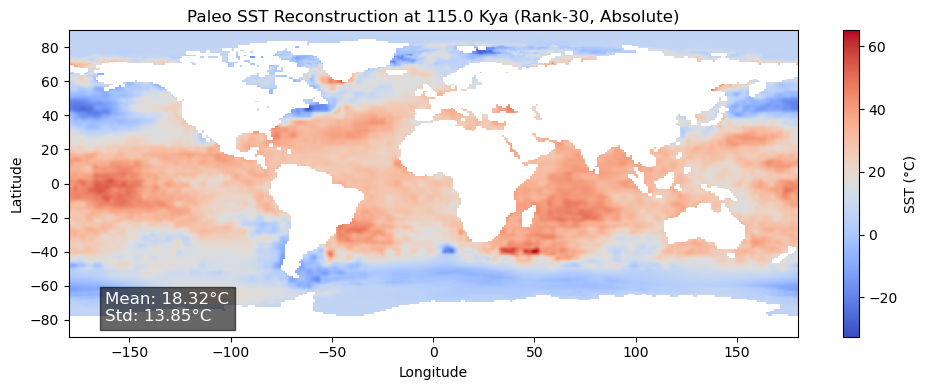

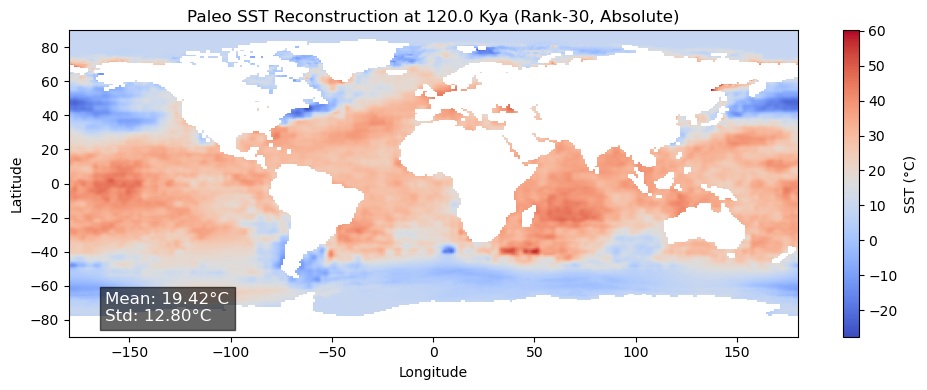

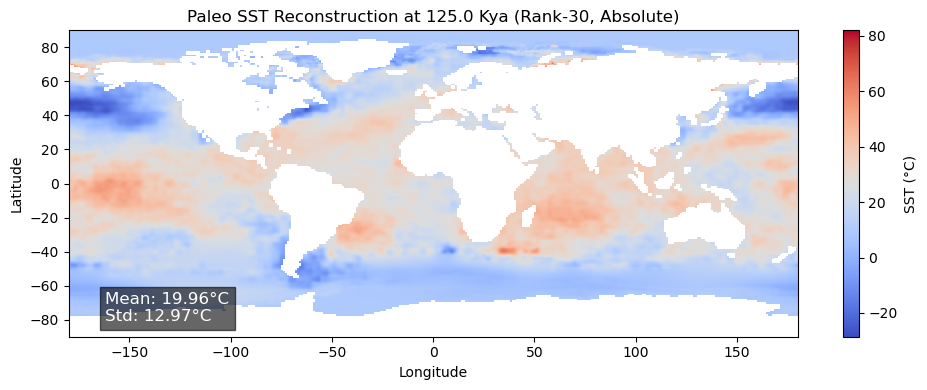

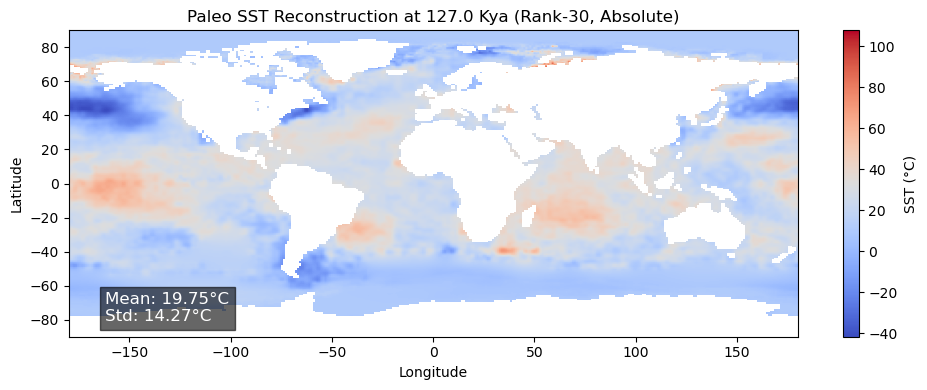

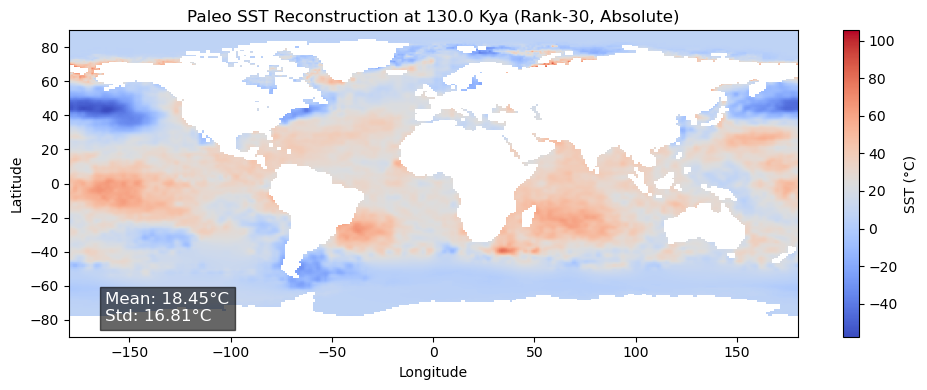

Paleo Variance Explained by Each of the 30 Modes:
  Mode  1:  50.95%
  Mode  2:   6.51%
  Mode  3:   1.94%
  Mode  4:   1.68%
  Mode  5:   0.18%
  Mode  6:   1.34%
  Mode  7:   2.31%
  Mode  8:   3.64%
  Mode  9:   0.26%
  Mode 10:   0.11%
  Mode 11:   4.66%
  Mode 12:   0.16%
  Mode 13:   7.08%
  Mode 14:   0.75%
  Mode 15:   0.60%
  Mode 16:   0.12%
  Mode 17:   0.31%
  Mode 18:   0.50%
  Mode 19:   0.46%
  Mode 20:   0.72%
  Mode 21:   1.86%
  Mode 22:   0.35%
  Mode 23:   3.72%
  Mode 24:   0.06%
  Mode 25:   0.23%
  Mode 26:   1.19%
  Mode 27:   2.28%
  Mode 28:   0.66%
  Mode 29:   2.75%
  Mode 30:   2.61%


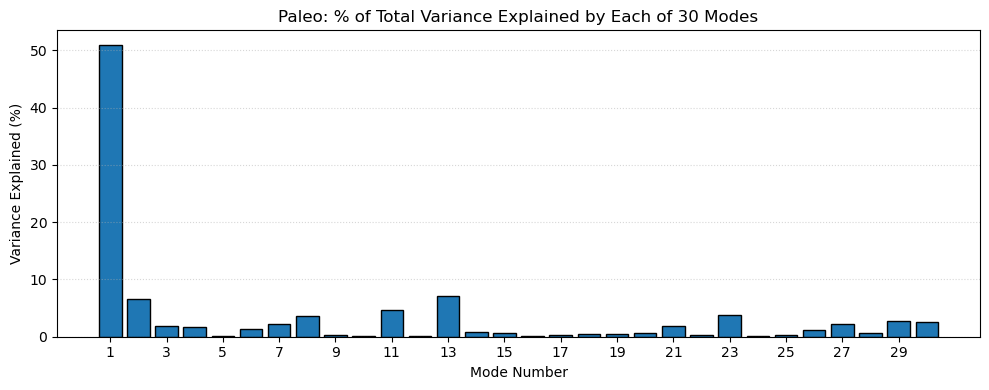

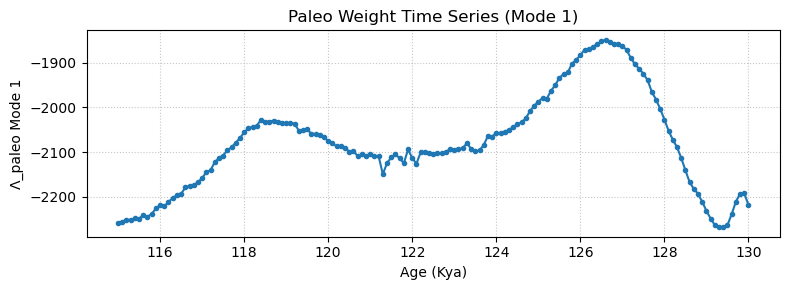

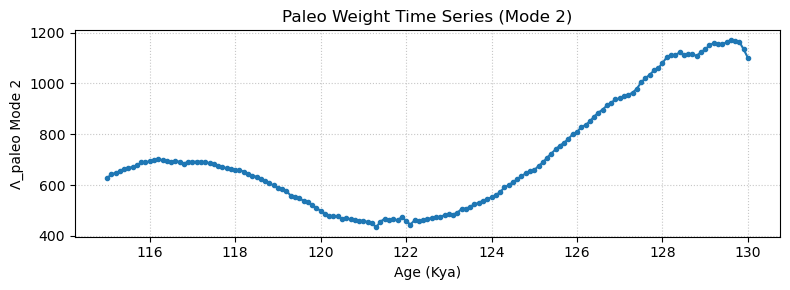

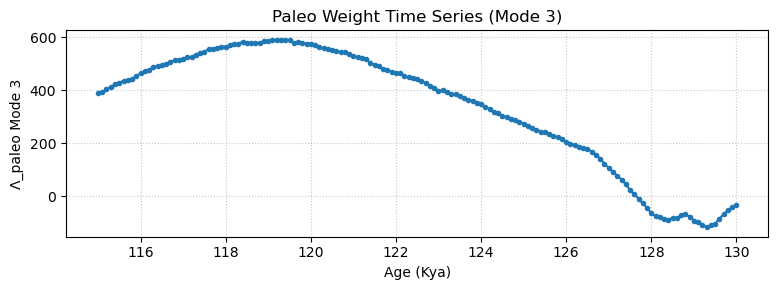

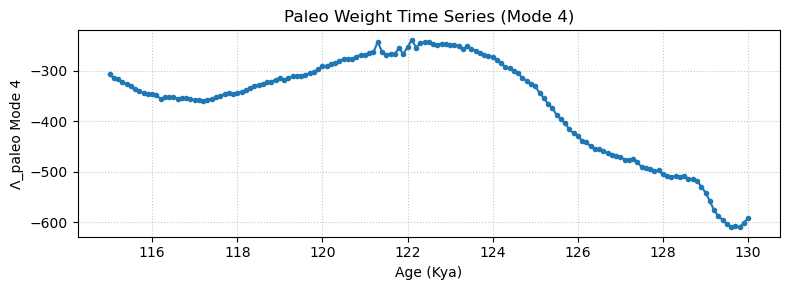

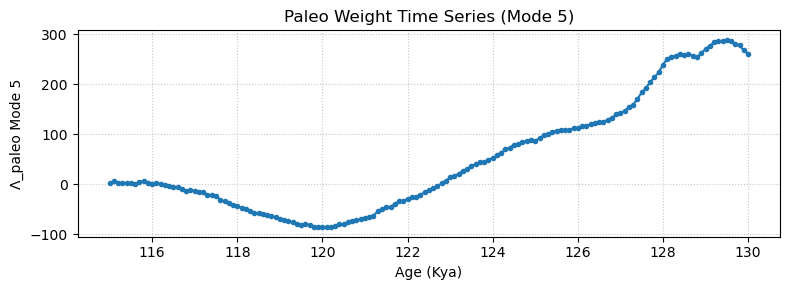

In [33]:
# 8) Build F_paleo (151 × 82) by reading column T (skip header), back-fill.
T_paleo = 151
F_paleo = np.full((T_paleo, N_cores), np.nan)

for j in range(N_cores):
    core_id = M.loc[j, "ID"]
    # Read column T, skip first row (header "SST mean"), next 151 rows are values
    df_sst_full = pd.read_excel(
        excel_file,
        sheet_name=core_id,
        header=None,
        usecols="T",
        skiprows=1,    # skip header row "SST mean"
        nrows=T_paleo
    )
    series = df_sst_full.iloc[:, 0]            # length = 151
    series_filled = series.fillna(method="bfill").values
    F_paleo[:, j] = series_filled

# 9) Standardize F_paleo row-wise: subtract each row’s mean (no division by σ)
row_mean_paleo = np.nanmean(F_paleo, axis=1, keepdims=True)  # (151,1)
F_paleo_anom = F_paleo - row_mean_paleo                        # (151,82)

# 10) Compute Lambda_paleo = F_paleo_anom × Beta  ⇒ (151×82) × (82×30) = (151×30)
Lambda_paleo = F_paleo_anom.dot(Beta)  # shape = (151, 30)

# 11) Reconstruct paleo SST anomaly on full 64800 grid: B_paleo = Lambda_paleo × Modern_PC
B_paleo = Lambda_paleo.dot(Modern_PC)  # (151×30) × (30×64800) ⇒ (151×64800)

# 12) Now compute absolute SST reconstruction for selected ages by adding back row_mean_paleo
#     Ages of interest: 115, 120, 125, 127, 130 Kya  ⇒ indices = 0, 50, 100, 120, 150
age_list = [115.0, 120.0, 125.0, 127.0, 130.0]
indices = [int(round((age - 115.0) / 0.1)) for age in age_list]  # [0, 50, 100, 120, 150]

# Prepare to plot 5 absolute‐SST reconstruction maps
for idx, age in zip(indices, age_list):
    # 12a) Anomaly flat vector at this paleo time
    B_flat = B_paleo[idx, :]       # length = 64800
    # 12b) Add back the row_mean_paleo for absolute SST
    absolute_flat = B_flat + row_mean_paleo[idx, 0]
    absolute_map = absolute_flat.reshape(nlat, nlon)

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(
        absolute_map,
        origin="lower",
        extent=[-180, 180, -90, 90],
        aspect="auto",
        cmap="coolwarm",
        vmin=np.nanmin(absolute_map),
        vmax=np.nanmax(absolute_map)
    )
    ax.set_title(f"Paleo SST Reconstruction at {age:.1f} Kya (Rank-{n_modes}, Absolute)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    # Overlay mean & std of the absolute SST for annotation
    mean_abs = np.nanmean(absolute_map)
    std_abs = np.nanstd(absolute_map)
    ax.text(
        0.05, 0.05,
        f"Mean: {mean_abs:.2f}°C\nStd: {std_abs:.2f}°C",
        transform=ax.transAxes,
        fontsize=12,
        color="white",
        bbox=dict(facecolor="black", alpha=0.6)
    )
    fig.colorbar(im, ax=ax, label="SST (°C)")
    plt.tight_layout()
    plt.show()

# 13) Compute percentage of total variance explained by each paleo weight
#     We measure each mode’s contribution as sum(Lambda_paleo[:,j]^2) / sum(all^2).
paleo_sq = Lambda_paleo**2
total_paleo_ss = paleo_sq.sum()
var_explained_paleo = paleo_sq.sum(axis=0) / total_paleo_ss * 100  # length = 30

# Print percentages
print("Paleo Variance Explained by Each of the 30 Modes:")
for i, pct in enumerate(var_explained_paleo, start=1):
    print(f"  Mode {i:2d}: {pct:6.2f}%")

# Plot paleo variance‐explained as a bar chart
plt.figure(figsize=(10, 4))
plt.bar(np.arange(1, n_modes+1), var_explained_paleo, edgecolor="black")
plt.xlabel("Mode Number")
plt.ylabel("Variance Explained (%)")
plt.title("Paleo: % of Total Variance Explained by Each of 30 Modes")
plt.xticks(np.arange(1, n_modes+1, 2))
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

# 14) Plot the first five paleo weight time series
ages_paleo = np.linspace(115.0, 130.0, T_paleo)  # 151 steps
for mode in range(5):
    plt.figure(figsize=(8, 3))
    plt.plot(ages_paleo, Lambda_paleo[:, mode], marker=".", linestyle="-")
    plt.xlabel("Age (Kya)")
    plt.ylabel(f"Λ_paleo Mode {mode+1}")
    plt.title(f"Paleo Weight Time Series (Mode {mode+1})")
    plt.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()

### Step 3.6 Reconstruction Animation

Absolute SST Animation saved to: paleo_absolute_sst_animation.gif


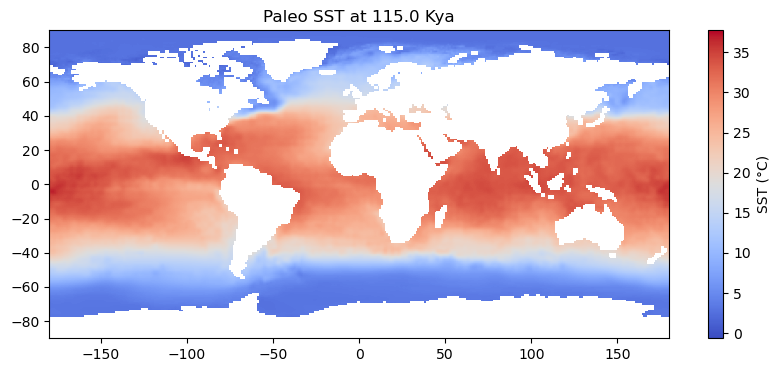

In [14]:
import matplotlib.animation as animation

# Combine anomaly + row_mean → absolute SST for all 151 frames,
# then reshape into (151, nlat, nlon) for easy indexing.
all_abs = (B_paleo + row_mean_paleo).reshape(151, nlat, nlon)

fig, ax = plt.subplots(figsize=(10, 4))

# Determine global color limits from the entire 151‐step stack
vmin = np.nanmin(all_abs)
vmax = np.nanmax(all_abs)

# Initial frame: start at 130.0 Kya, which is index 150
# Use absolute SST
initial_idx = 150
im = ax.imshow(
    all_abs[initial_idx],
    origin="lower",
    extent=[-180, 180, -90, 90],
    aspect="auto",
    cmap="coolwarm",
    vmin=vmin,
    vmax=vmax
)
cbar = fig.colorbar(im, ax=ax, label="SST (°C)")
title = ax.set_title(f"The Last Interglacial: Reconstructed SST at {130.0:.1f} Kya")

def update(frame):
    # 'frame' runs from 0 to 150; map to paleo_idx descending
    paleo_idx = 150 - frame
    age = 115.0 + 0.1 * paleo_idx  # e.g. frame=0 → paleo_idx=150 → age=130.0
    im.set_array(all_abs[paleo_idx])
    title.set_text(f"Paleo SST at {age:.1f} Kya")
    return [im, title]

anim = animation.FuncAnimation(
    fig,
    update,
    frames=151,
    blit=True
)

# Save at 30 frames per second
gif_path = "paleo_absolute_sst_animation.gif"
writer = animation.PillowWriter(fps=30)
anim.save(gif_path, writer=writer)

print(f"Absolute SST Animation saved to: {gif_path}")

SST Anomaly Animation saved to: paleo_absolute_sst_animation.gif


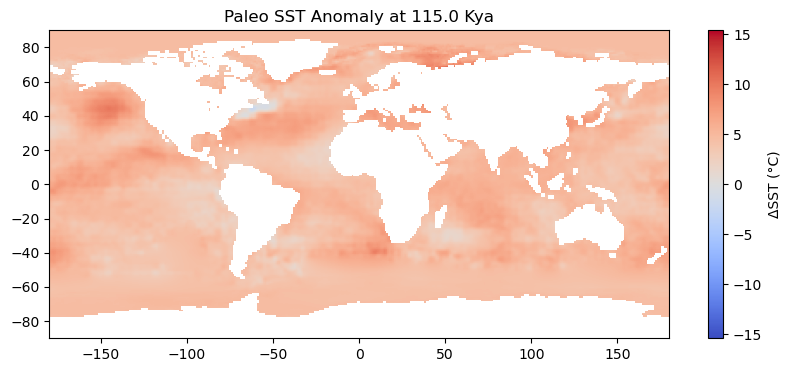

In [15]:
# Create absolute anomaly plots: Reconstructed Absolute Paleo SST - Modern SST
all_anomaly = all_abs - modern_mean_map[np.newaxis, :, :]  # shape = (151, nlat, nlon)

fig, ax = plt.subplots(figsize=(10, 4))
vmin_anom = -np.nanmax(all_anomaly)
vmax_anom = np.nanmax(all_anomaly)

# Initial frame: index 150 (130.0 Kya)
initial_idx = 150
im_anim_anom = ax.imshow(
    all_anomaly[initial_idx],
    origin="lower",
    extent=[-180, 180, -90, 90],
    aspect="auto",
    cmap="coolwarm",
    vmin=vmin_anom,
    vmax=vmax_anom
)
cbar = fig.colorbar(im_anim_anom, ax=ax, label="ΔSST (°C)")
title = ax.set_title(f"Paleo SST Anomaly at {130.0:.1f} Kya")

def update(frame):
    paleo_idx = 150 - frame
    age = 115.0 + 0.1 * paleo_idx
    im_anim_anom.set_array(all_anomaly[paleo_idx])
    title.set_text(f"Paleo SST Anomaly at {age:.1f} Kya")
    return [im_anim_anom, title]

anim_anom = animation.FuncAnimation(fig, update, frames=151, blit=True)

# Save at 30 fps
gif_path_anom = "paleo_sst_anomaly_animation.gif"
writer = animation.PillowWriter(fps=30)
anim_anom.save(gif_path_anom, writer=writer)

print(f"SST Anomaly Animation saved to: {gif_path}")

#### Old code from EOF V1 notebook

In [29]:
# Open the Excel file and retrieve sheet names
excel_file = "SST_Hoffman_Harmonized_AC_ES.xlsx"
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

# List of sheet names to skip because they are "info sheets"
non_sst_sheets = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me"
]
records = []

for sheet in sheet_names:
    # Skip any sheets in the non-sst list
    if sheet in non_sst_sheets:
        continue

    try:
        # Read columns A–C, first two rows
        df_base = pd.read_excel(
            excel_file,
            sheet_name=sheet,
            header=None,
            usecols="A:C",
            nrows=2
        )
        # Extract row 2 (index 1)
        ID        = sheet
        longitude = df_base.iloc[1, 1]
        latitude  = df_base.iloc[1, 2]
    except Exception as e:
        print(f"Skipping sheet {sheet} (base read error): {e}")
        continue

    try:
        # Read column T, first 142 rows
        df_sst = pd.read_excel(
            excel_file,
            sheet_name=sheet,
            header=None,
            usecols="T",
            nrows=142
        )
        # Extract the specific SST rows
        sst_115 = df_sst.iloc[1,   0]  # cell T2   → index 1
        sst_120 = df_sst.iloc[51,  0]  # cell T52  → index 51
        sst_125 = df_sst.iloc[101, 0]  # cell T102 → index 101
        sst_127 = df_sst.iloc[121, 0]  # cell T122 → index 121
        sst_129 = df_sst.iloc[141, 0]  # cell T142 → index 141
    except Exception as e:
        print(f"Skipping sheet {sheet} (SST read error): {e}")
        continue

    records.append({
        "ID":        ID,
        "longitude": longitude,
        "latitude":  latitude,
        "sst_115":   sst_115,
        "sst_120":   sst_120,
        "sst_125":   sst_125,
        "sst_127":   sst_127,
        "sst_129":   sst_129
    })

# Build the final DataFrame
df_LIG = pd.DataFrame(records)

def round_to_nearest_half(x):
    """Round to nearest 0.5, always ending with .5"""
    base = np.floor(x)  # Get integer part
    
    return base + 0.5

# Round coordinates
df_LIG['lon_round'] = df_LIG['longitude'].apply(round_to_nearest_half)
df_LIG['lat_round'] = df_LIG['latitude'].apply(round_to_nearest_half)

# Clip to valid ranges
df_LIG['lon_round'] = df_LIG['lon_round'].clip(lower=-179.5, upper=179.5)
df_LIG['lat_round'] = df_LIG['lat_round'].clip(lower=-89.5, upper=89.5)

# Remove replicated cores
dup_mask = df_LIG.duplicated(subset=['lat_round', 'lon_round'], keep=False)
duplicated_rows = df_LIG[dup_mask]

# List of row positions to remove (0-based)
to_drop_positions = [1, 5, 17, 21, 39, 64, 73, 57, 71, 76, 79, 80, 82, 84, 85, 88, 90, 91, 94, 97, 99, 102]

# Keep only those positions that actually exist in the DataFrame
valid_positions = [pos for pos in to_drop_positions if pos < len(df_LIG)]

# Drop by position: map positions → index labels, then drop
df_LIG.drop(index=df_LIG.index[valid_positions], inplace=True)

# The DataFrame now has those rows removed, index labels unchanged

# Preview
print(df_LIG.head(), "\n")
print("The shape of the LIG data frame is: " df_LIG.shape) # Should be (82, 10)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (699546189.py, line 105)